## playground for hebbian learning 
a few sanity checks to gain deeper understanding of why SLA works the way it does 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.spatial.distance import squareform,pdist
from scipy.stats import multivariate_normal
from copy import deepcopy

In [2]:
def gen2Dgauss(x_mu=.0, y_mu=.0, xy_sigma=.1, n=20):
    """
    generates two-dimensional gaussian blob
    """
    xx,yy = np.meshgrid(np.linspace(0, 1, n),np.linspace(0, 1, n))
    gausspdf = multivariate_normal([x_mu,y_mu],[[xy_sigma,0],[0,xy_sigma]])
    x_in = np.empty(xx.shape + (2,))
    x_in[:, :, 0] = xx; x_in[:, :, 1] = yy
    return gausspdf.pdf(x_in)


def mk_block_wctx(context, do_shuffle, c_scaling=1):
    """
    generates block of experiment
    Input:
      - task  : 'task_a' or 'task_b'
      - do_shuffle: True or False, shuffles  values
    """
    resolution = 5
    n_units = resolution**2
    l, b = np.meshgrid(np.linspace(0.2, .8, 5),np.linspace(0.2, .8, 5))
    b = b.flatten()
    l = l.flatten()
    r_s, r_n = np.meshgrid(np.linspace(-2, 2, 5),np.linspace(-2, 2, 5))
    r_s = r_s.flatten()
    r_n = r_n.flatten()
    val_l, val_b = np.meshgrid(np.linspace(1, 5, 5),np.linspace(1, 5, 5))
    val_b = val_b.flatten()
    val_l = val_l.flatten()

    #plt.figure()
    ii_sub = 1
    blobs = np.empty((25,n_units))
    for ii in range(0,25):
        blob = gen2Dgauss(x_mu=b[ii], y_mu=l[ii],xy_sigma=0.08,n=resolution)
        blob = blob/ np.max(blob)
        ii_sub += 1
        blobs[ii,:] = blob.flatten()
    x = blobs
    if context == 'task_a':
        x1 = np.append(blobs,c_scaling * np.ones((blobs.shape[0],1)),axis=1)
        x1 = np.append(x1,np.zeros((blobs.shape[0],1)),axis=1)
        reward = r_n
    elif context == 'task_b':
        x1 = np.append(blobs,np.zeros((blobs.shape[0],1)),axis=1)
        x1 = np.append(x1,c_scaling * np.ones((blobs.shape[0],1)),axis=1)
        reward = r_s

    feature_vals = np.vstack((val_b,val_l)).T
    if do_shuffle:
        ii_shuff = np.random.permutation(25)
        x1 = x1[ii_shuff,:]
        feature_vals = feature_vals[ii_shuff,:]
        reward = reward[ii_shuff]
    return x1, reward, feature_vals




def make_dataset(ctx_scaling=1, training_schedule='blocked',n_episodes=10, ctx_avg=True, ctx_avg_window=10, centering=True):
    """
    makes dataset for experiment
    """
    
    random_state = np.random.randint(999)

    x_task_a,y_task_a,f_task_a = mk_block_wctx('task_a',0,ctx_scaling)
    y_task_a = y_task_a[:,np.newaxis]
    l_task_a = (y_task_a>0).astype('int')

    x_task_b,y_task_b,f_task_b = mk_block_wctx('task_b',0,ctx_scaling)
    y_task_b = y_task_b[:,np.newaxis]
    l_task_b = (y_task_b>0).astype('int')

    x_in = np.concatenate((x_task_a,x_task_b),axis=0)
    y_rew = np.concatenate((y_task_a,y_task_b), axis=0)
    y_true = np.concatenate((l_task_a,l_task_b), axis=0)

    # define datasets (duplicates for shuffling)
    data = {}
    data['x_task_a'] = x_task_a
    data['y_task_a'] = y_task_a
    data['l_task_a'] = l_task_a

    data['x_task_b'] = x_task_b
    data['y_task_b'] = y_task_b
    data['l_task_b'] = l_task_b

    data['x_all'] = x_in
    data['y_all'] = y_rew
    data['l_all'] = y_true

    if training_schedule == 'interleaved':
        data['x_train'] = np.vstack(tuple([shuffle(data['x_all'],random_state = i+random_state) for i in range(n_episodes)]))
        data['y_train'] = np.vstack(tuple([shuffle(data['y_all'],random_state = i+random_state) for i in range(n_episodes)]))
        data['l_train'] = np.vstack(tuple([shuffle(data['l_all'],random_state = i+random_state) for i in range(n_episodes)]))
    elif training_schedule == 'blocked':
        data['x_train'] = np.vstack((
            np.vstack(tuple([shuffle(data['x_task_a'],random_state = i+random_state) for i in range(n_episodes)])),
            np.vstack(tuple([shuffle(data['x_task_b'],random_state = i+random_state) for i in range(n_episodes)]))))
        data['y_train'] = np.vstack((
            np.vstack(tuple([shuffle(data['y_task_a'],random_state = i+random_state) for i in range(n_episodes)])),
            np.vstack(tuple([shuffle(data['y_task_b'],random_state = i+random_state) for i in range(n_episodes)]))))
        data['l_train'] = np.vstack((
            np.vstack(tuple([shuffle(data['l_task_a'],random_state = i+random_state) for i in range(n_episodes)])),
            np.vstack(tuple([shuffle(data['l_task_b'],random_state = i+random_state) for i in range(n_episodes)]))))    
    else:
        print('Unknown training schedule parameter')
        

    if ctx_avg and ctx_avg_window>0:    
        data['x_train'][:,-2] = pd.Series(data['x_train'][:,-2]).rolling(window=ctx_avg_window, min_periods=1).mean()
        data['x_train'][:,-1] = pd.Series(data['x_train'][:,-1]).rolling(window=ctx_avg_window, min_periods=1).mean()

    if centering == True:
        sc = StandardScaler(with_std=False)
        data['x_train'] = sc.fit_transform(data['x_train'])
        data['x_task_a'] = sc.transform(data['x_task_a'])
        data['x_task_b'] = sc.transform(data['x_task_b'])
        data['x_all'] = sc.transform(data['x_all'])  
    return data


def biplot(score,coeff,pcax,pcay,labels=None):
    '''
    pyplot doesn't support biplots as matlab does. got this script from
        https://sukhbinder.wordpress.com/2015/08/05/biplot-with-python/
    
    USAGE: biplot(score,pca.components_,1,2,labels=categories)
    '''
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n=score.shape[1]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    print(n)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5) 
        if labels is None:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()
    
def plot_results():
    
    plt.figure(figsize=(16,10))
    plt.subplot(2,2,1)
    plt.plot([np.linalg.norm(wi) for wi in delta_ws])
    plt.title('norm of ' + r'$\Delta w$')
    plt.xlabel('iter')
    plt.ylabel('norm')
    plt.plot([n_trials//2, n_trials//2],plt.ylim(),'k:')
    plt.subplot(2,2,2)
    plt.plot([np.linalg.norm(wi) for wi in ws])
    plt.title('norm of ' + r'$w$')
    plt.xlabel('iter')
    plt.ylabel('norm')
    plt.plot([n_trials//2, n_trials//2],plt.ylim(),'k:')
    plt.subplot(2,2,3)
    a = plt.plot([wi[-1] for wi in ws],color='blue')
    b = plt.plot([wi[-2] for wi in ws],color='orange')
    plt.legend(['task a', 'task b'])
    plt.title('context units')
    plt.xlabel('iter')
    plt.ylabel('weight')
    plt.plot([n_trials//2, n_trials//2],plt.ylim(),'k:')
    plt.subplot(2,2,4)
    plt.imshow(np.asarray(ws).T)
    plt.xlabel('iter')
    plt.ylabel('input')
    plt.plot([n_trials//2, n_trials//2],plt.ylim(),'k:')
    plt.title('all weights')
    plt.suptitle(r'$\eta = $' +f'{eta}' + r'  $\sigma_{init} = $' + f'{sigma}',fontweight='normal',fontsize=18)
    plt.tight_layout()
    
def plot_initsign_results(init_weights=[1,-1]):
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot([np.linalg.norm(wi) for wi in delta_ws])
    plt.title('norm of ' + r'$\Delta w$' )
    plt.xlabel('iter')
    plt.ylabel('norm')
    plt.plot([n_trials//2, n_trials//2],plt.ylim(),'k:')
    plt.subplot(1,3,2)
    plt.plot([np.linalg.norm(wi) for wi in ws])
    plt.title('norm of ' + r'$w$')
    plt.xlabel('iter')
    plt.ylabel('norm')
    plt.plot([n_trials//2, n_trials//2],plt.ylim(),'k:')
    plt.subplot(1,3,3)
    a = plt.plot([wi[-1] for wi in ws],color='blue')
    b = plt.plot([wi[-2] for wi in ws],color='orange')
    plt.legend(['task a', 'task b'])
    plt.title('context weights')
    plt.xlabel('iter')
    plt.ylabel('weight')
    plt.plot([n_trials//2, n_trials//2],plt.ylim(),'k:')
    plt.suptitle(r'$\eta = $' +f'{eta}' + r'  $w_{init} = $' + f'{init_weights}',fontweight='normal',fontsize=16)
    plt.tight_layout()
    
def plot_ghasla_results():
    
    #stats:
    plt.figure(figsize=(10,6),dpi=300)
    plt.subplot(2,3,1)
    plt.plot([np.linalg.norm(wi) for wi in delta_ws])
    plt.title('norm of ' + r'$\Delta W$' ,fontsize=8)
    plt.xlabel('iter')
    plt.ylabel('norm')
    plt.plot([n_trials//2, n_trials//2],plt.ylim(),'k:')
    
    plt.subplot(2,3,2)
    plt.plot([np.linalg.norm(wi) for wi in ws])
    plt.title('norm of ' + r'$W$' ,fontsize=8)
    plt.xlabel('iter')
    plt.ylabel('norm')
    plt.plot([n_trials//2, n_trials//2],plt.ylim(),'k:')
    
    plt.subplot(2,3,3)    
    a = plt.plot([wi[-2] for wi in ws],color='blue')
    b = plt.plot([wi[-1] for wi in ws],color='orange')
    plt.legend([a[0],b[0]],['task a', 'task b'],frameon=False)
    plt.title('context to hidden weights' ,fontsize=8)
    plt.xlabel('iter')
    plt.ylabel('weight')
    plt.plot([n_trials//2, n_trials//2],plt.ylim(),'k:')
    
    plt.subplot(2,3,4)
    plt.plot([np.corrcoef(wi[-1,:],wi[-2,:])[0,1] for wi in ws])
    plt.title('correlation between ctx weight vectors' ,fontsize=8)
    plt.xlabel('iter')
    plt.ylabel("pearson's r")
    plt.plot([n_trials//2, n_trials//2],plt.ylim(),'k:')
    
    
    plt.subplot(2,3,5)
    ta = []
    tb = []
    for W in ws:
        
        if W.shape[0]==2:
            ya = np.maximum((data['x_task_a'][:,-2:]@W),0).mean(0)
            yb = np.maximum((data['x_task_b'][:,-2:]@W),0).mean(0)
        else:
            ya = np.maximum((data['x_task_a']@W),0).mean(0)
            yb = np.maximum((data['x_task_b']@W),0).mean(0)
        ta.append(np.mean((ya>0)&(yb==0)))
        tb.append(np.mean((ya==0)&(yb>0)))    
    plt.plot(ta,color='blue')
    plt.plot(tb,color='orange')
    plt.title('proportion of task-specific units' ,fontsize=8)
    plt.yticks(ticks=np.arange(0,1.1,0.1),labels=(np.arange(0,1.1,0.1)*100).astype('int'))
    plt.xlabel('iter')
    plt.ylabel('percentage')
    plt.legend(['task a','task b'],frameon=False)
    plt.suptitle('Learning Dynamics, ' + r'$\eta = $' +f'{eta}' + r'  $\sigma_{init} = $' + f'{sigma}',fontweight='normal',fontsize=12)
    plt.tight_layout()
    
    # connectivity matrix:
    plt.figure(figsize=(8,3),dpi=300)
    plt.subplot(2,1,1)
    plt.imshow(ws[0])
    plt.ylabel('input unit')
    plt.xlabel('hidden unit / PC')
    plt.title('Initial Connectivity Matrix',fontsize=8)
    
    
    plt.subplot(2,1,2)
    plt.imshow(ws[-1])
    plt.ylabel('input unit')
    plt.xlabel('hidden unit / PC')
    plt.title('Endpoint Connectivity Matrix',fontsize=8)
    plt.suptitle('Weights',fontweight='normal',fontsize=12)
    
    plt.tight_layout()
    
    # receptive fields:
#     plt.figure(figsize=(25,5))
    

In [3]:
data = make_dataset(n_episodes=1,ctx_scaling=5,ctx_avg=False,centering=False)

Text(0.5, 0, 'feature')

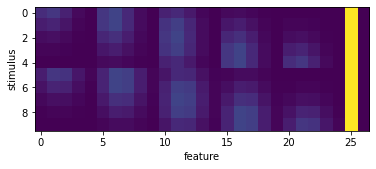

In [4]:
plt.imshow(data['x_all'][:10,:])
plt.ylabel('stimulus')
plt.xlabel('feature')

In [36]:
data['x_train'][:10,-2:]

array([[5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.]])

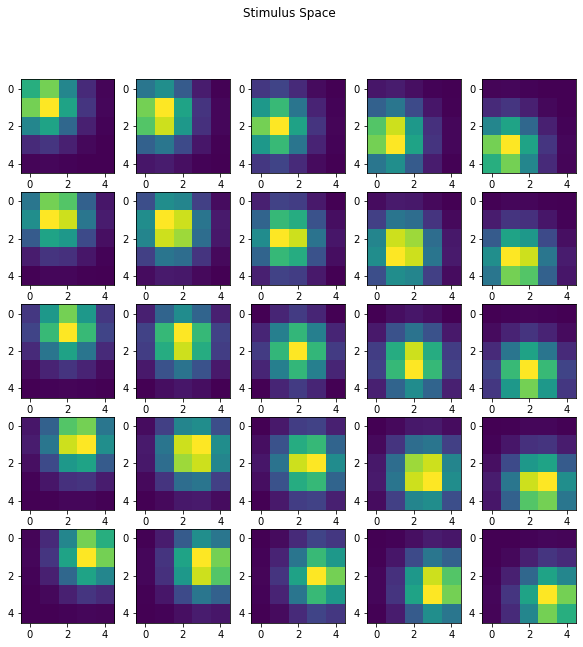

In [37]:
f,axs = plt.subplots(5,5,figsize=(10,10))
axs = axs.ravel()
for ii,ax in enumerate(axs):
    ax.imshow(data['x_all'][ii,:25].reshape((5,5)))
_ = f.suptitle('Stimulus Space')

## PCA on inputs 
Sanity check, should recover context as largest axis of variation

In [4]:
from sklearn.decomposition import PCA
from copy import deepcopy
pca = PCA(n_components=27)
data = make_dataset(n_episodes=1,ctx_scaling=5,ctx_avg=False,centering=True)


pca.fit(data['x_train'])


PCA(n_components=27)

In [5]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings.shape
pca.components_.shape

(27, 27)

In [6]:
scores = data['x_train']@pca.components_.T
scores.shape

(50, 27)

In [7]:
# c,t,m = np.meshgrid(np.arange(1,6),np.arange(1,3),np.arange(1,6))
# c,m,t = c.flatten(), m.flatten(), t.flatten()
# labels = ['c'+str(ic)+'m'+str(im)+'_t'+str(it) for ic,im,it in zip(c,m,t)]
# labels_t = ['t'+str(it) for it in t]
labels = ['']*25 + ['context1'] + ['context2']

27


Text(0.5, 1.0, 'Biplot')

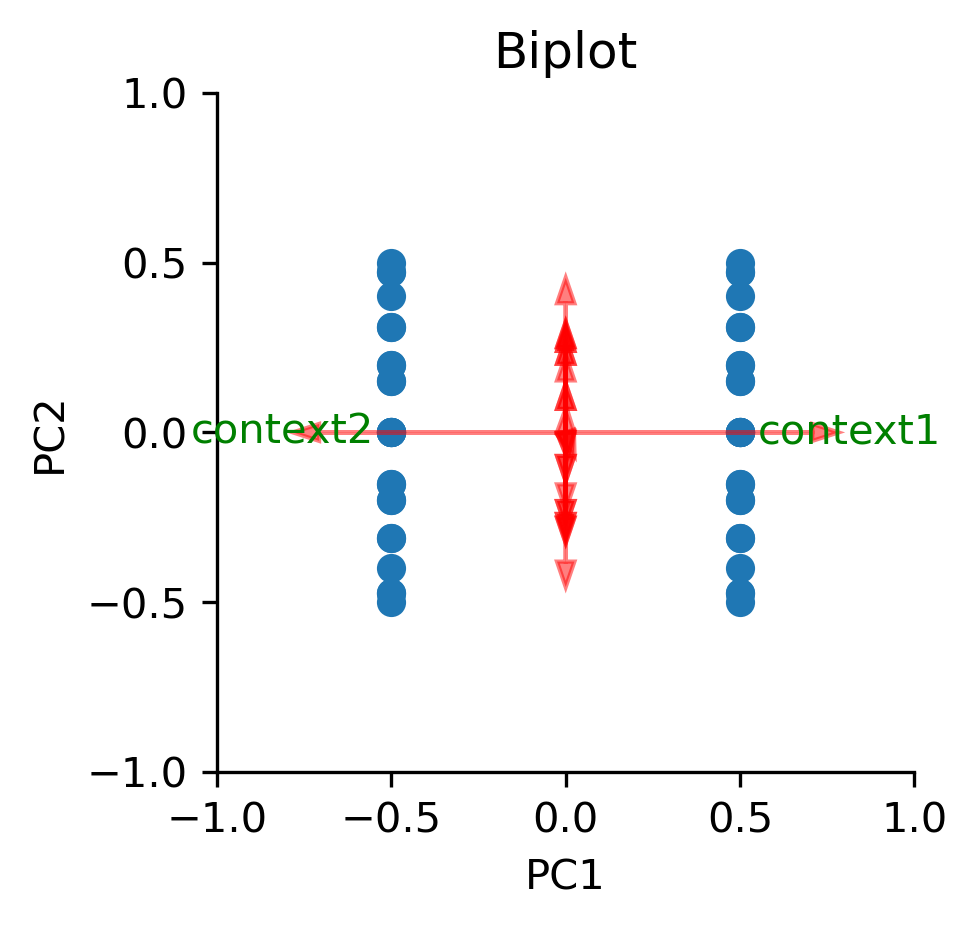

In [28]:
%matplotlib inline



score = scores
coeff = pca.components_.T
pcax = 1
pcay =2

plt.figure(figsize=(3,3),dpi=300)

pca1=pcax-1
pca2=pcay-1
xs = score[:,pca1]
ys = score[:,pca2]
n=score.shape[1]
scalex = 1.0/(xs.max()- xs.min())
scaley = 1.0/(ys.max()- ys.min())
plt.scatter(xs*scalex,ys*scaley)
print(n)
for i in range(n):
    plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5, head_width=0.05) 
    if labels is None:
        plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
    else:
        plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xticks(np.arange(-1,1.1,0.5))
plt.yticks(np.arange(-1,1.1,0.5))
plt.xlabel("PC{}".format(pcax))
plt.ylabel("PC{}".format(pcay))
# plt.grid()
sns.despine()
plt.title('Biplot')

Text(0, 0.5, "'hidden nodes' / PCs")

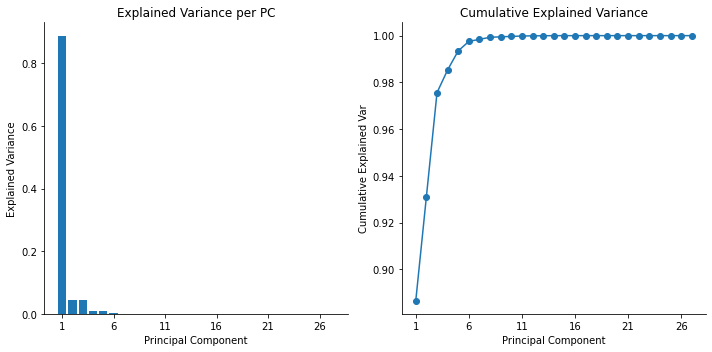

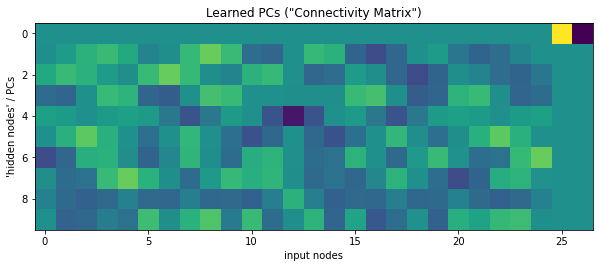

In [63]:
f = plt.figure(figsize=(10,5))
plt.subplot(1,2,1) 
plt.bar(np.arange(len(pca.explained_variance_)),pca.explained_variance_/np.sum(pca.explained_variance_))
ax = plt.gca()
ax.set(xlabel='Principal Component',ylabel='Explained Variance',title='Explained Variance per PC')
ax.set_xticks(np.arange(0,27,5))
ax.set_xticklabels(np.arange(1,27,5))

plt.subplot(1,2,2)
plt.plot(np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_),'o-')
ax = plt.gca()
ax.set(xlabel='Principal Component',ylabel='Cumulative Explained Var',title='Cumulative Explained Variance')
ax.set_xticks(np.arange(0,27,5))
ax.set_xticklabels(np.arange(1,27,5))

plt.tight_layout()
sns.despine()
# Visualise learned components, interpret as connectivity matrix
plt.figure(figsize=(10,5))
plt.imshow(pca.components_[:10,:])
plt.title('Learned PCs ("Connectivity Matrix")')
plt.xlabel('input nodes')
plt.ylabel("'hidden nodes' / PCs")

In [64]:
# are ctx vectors orthogonal:
print(np.isclose(pca.components_[:,-1].T@pca.components_[:,-2],0))
# what are the ctx to hidden weights for the first pc
print(pca.components_[1,-2:])

True
[-3.35081095e-17  3.35081095e-17]


Text(0, 0.5, 'ctx weight')

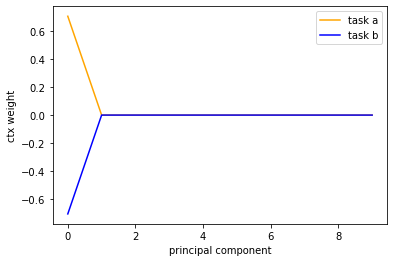

In [65]:
# learned principal component weights
a = plt.plot(pca.components_[:10,-2],'-',color='orange')
b = plt.plot(pca.components_[:10,-1],'-',color='blue')
plt.legend(['task a','task b'])
plt.xlabel('principal component')
plt.ylabel('ctx weight')

## Hebbian Learning on inputs
This should arrive at the same solution as PCA, but from blocked data


### Hebbian Learning with a single hidden unit
Let's verify that a single unit strengthens the connections between the context units and the hidden unit:  
$$ \Delta \textbf{w} = \eta y\textbf{x} $$


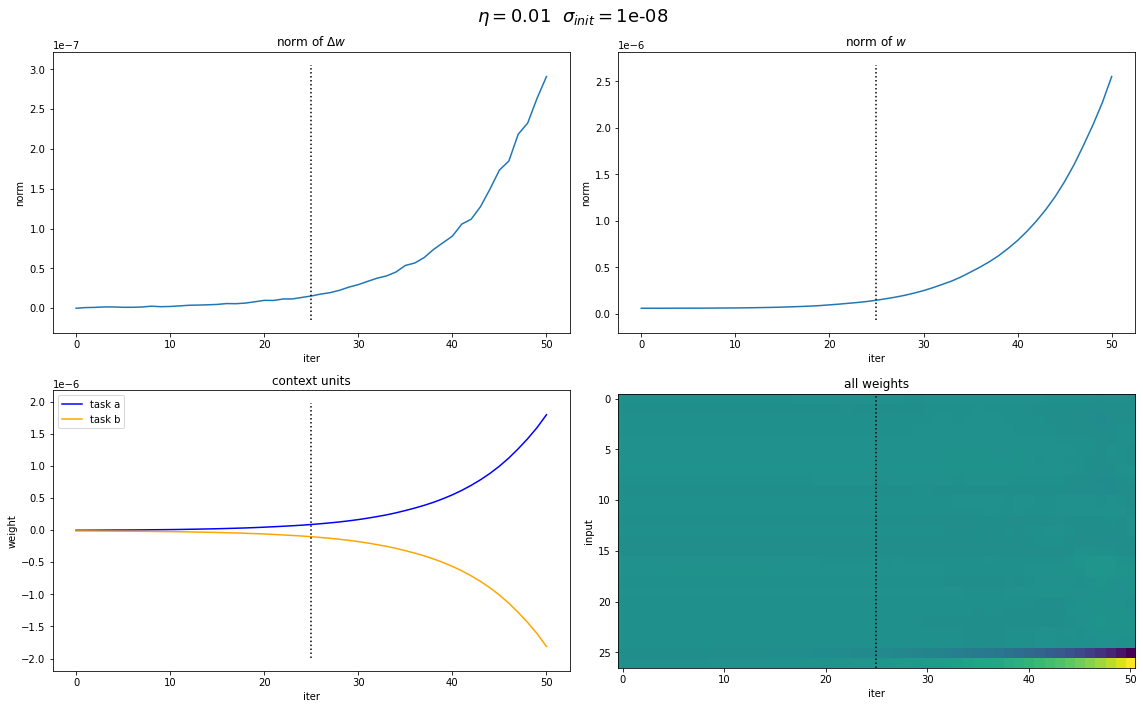

In [50]:
eta = 1e-2
sigma = 1e-8
n_episodes = 1
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=5,training_schedule='blocked',ctx_avg=False,centering=True)
w = np.random.randn(27)*sigma
delta_ws = []
ws = []
delta_ws.append(0)
ws.append(deepcopy(w))
X = data['x_train']
for x in X:
    y = w.T@x    
    dw = eta*y*x    
    w += dw
    delta_ws.append(dw)
    ws.append(deepcopy(w))
plot_results()

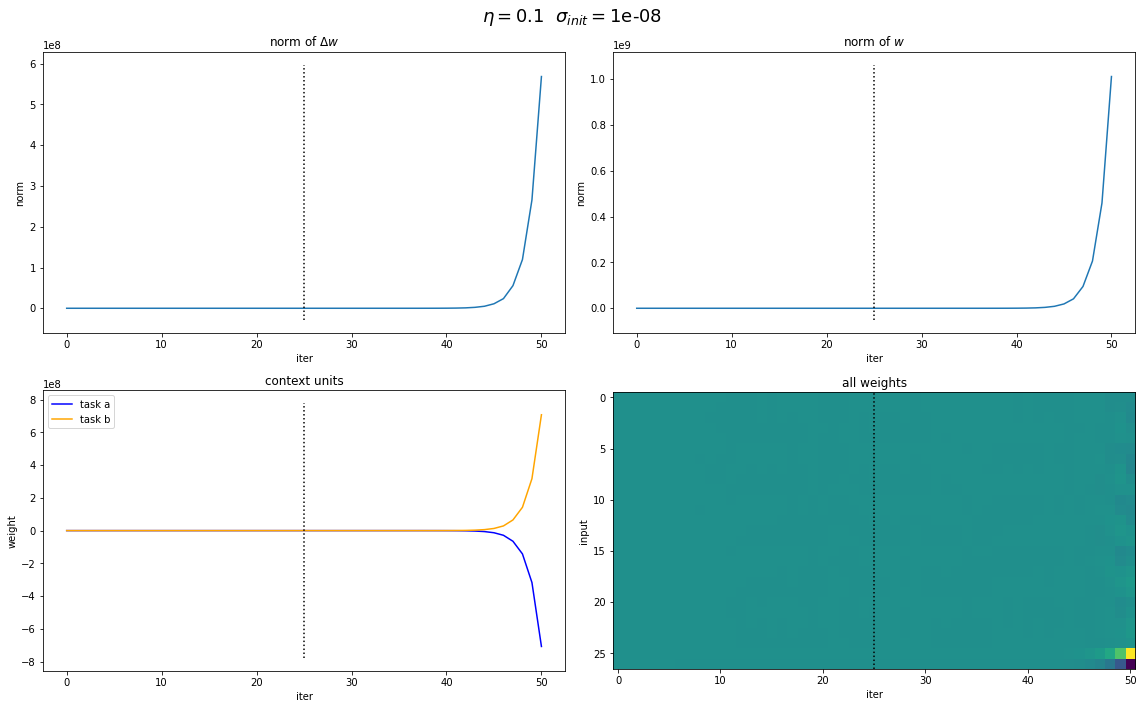

In [51]:
# same but with larger learning rate
eta = 1e-1
sigma = 1e-8
n_episodes = 1
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=5,training_schedule='blocked',ctx_avg=False)
w = np.random.randn(27)*sigma
delta_ws = []
ws = []
delta_ws.append(0)
ws.append(deepcopy(w))
X = data['x_train']
for x in X:
    y = w.T@x    
    dw = eta*y*x    
    w += dw
    delta_ws.append(dw)
    ws.append(deepcopy(w))
plot_results()

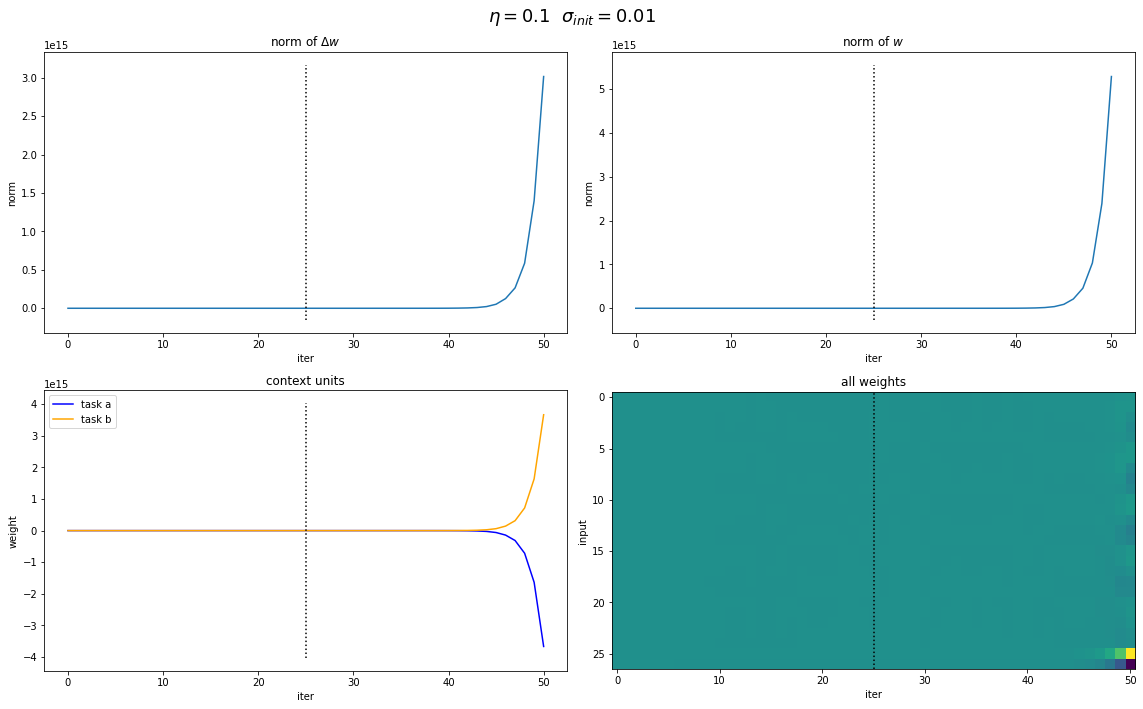

In [52]:
# larger weights at init
eta = 1e-1
sigma = 1e-2
n_episodes = 1
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=5,training_schedule='blocked',ctx_avg=False)
w = np.random.randn(27)*sigma
delta_ws = []
ws = []
delta_ws.append(0)
ws.append(deepcopy(w))
X = data['x_train']
for x in X:
    y = w.T@x    
    dw = eta*y*x    
    w += dw
    delta_ws.append(dw)
    ws.append(deepcopy(w))
plot_results()

### Oja's Rule with a single hidden unit
The result above suggests that connections between the two context units (input 26 and 27 in subplot 2,2) get anticorrelated as training progresses. Unless the learning rate is small, weights grow really large. To prevent weights from exploding, we perform updates with Oja's rule, which adds weight decay:
$$ \Delta \textbf{w} = \eta (y\textbf{x} - y^2\textbf{w}) = \eta y(\textbf{x} - y\textbf{w})$$

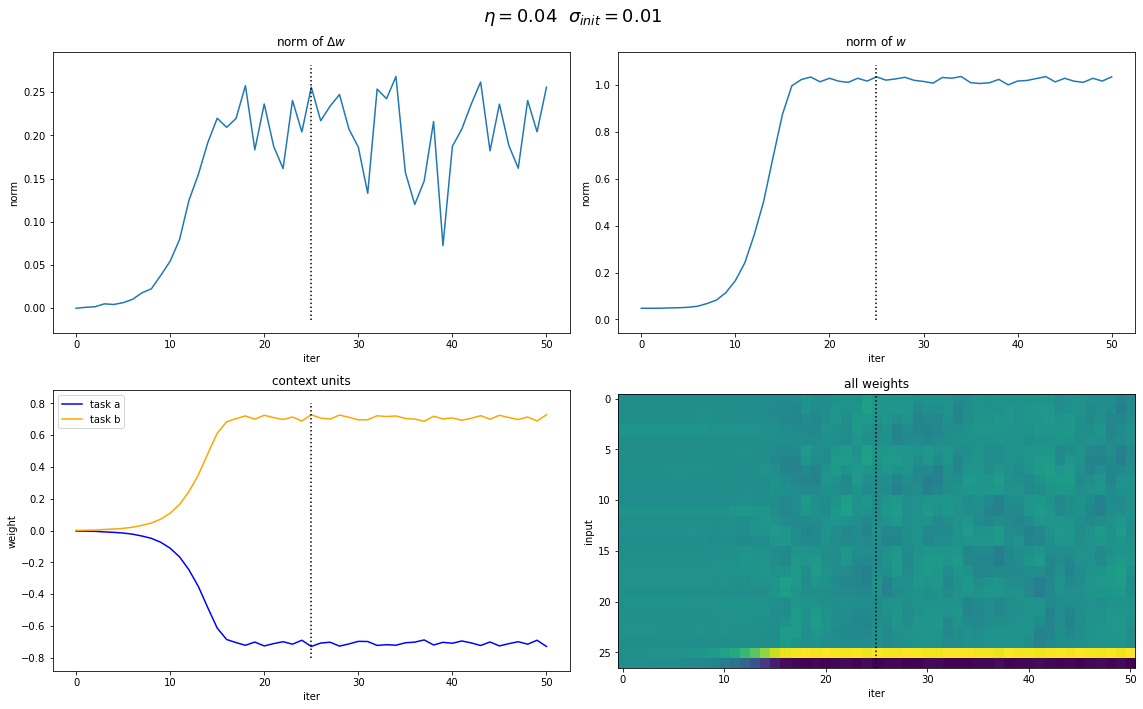

In [53]:
# now with Oja's rule
eta = 4e-2
sigma = 1e-2
n_episodes = 1
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=5,training_schedule='blocked',ctx_avg=False)
w = np.random.randn(27)*sigma
delta_ws = []
ws = []
delta_ws.append(0)
ws.append(deepcopy(w))
X = data['x_train']
for x in X:
    y = w.T@x    
    dw = eta*y*(x-y*w.T)    
    w += dw
    delta_ws.append(dw)
    ws.append(deepcopy(w))
plot_results()

#### How do the results depend on the sign of the weights at initialisation?
Potential problem: What if weights have to be anti-correlated from the start and Hebb only exploits this pre-existing structure?  Let's leave the input nodes aside and focus only on the two context nodes. How does convergence depend on the initial values for the context weights?   
Intuition: We need to break symmetry. That is, weights should have different magnitude, otherwise they cancel each other out due to the (1,-1) inputs. But the sign may not matter.   
Setup:
Inputs are c*(1,-1) for task 1, followed by c*(-1,1) for task 2, where c is a scaling factor.
Weights are again updated with Oja's rule.


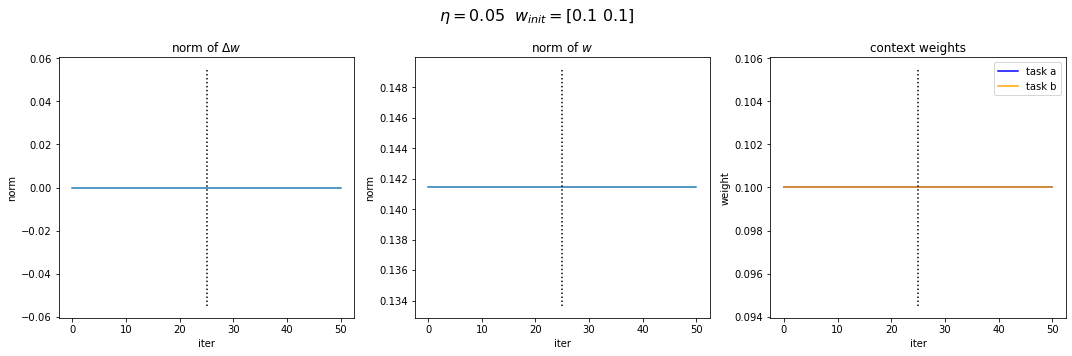

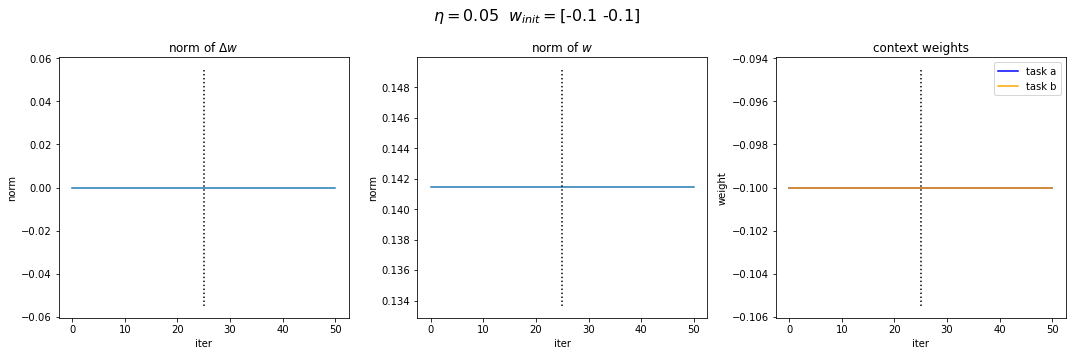

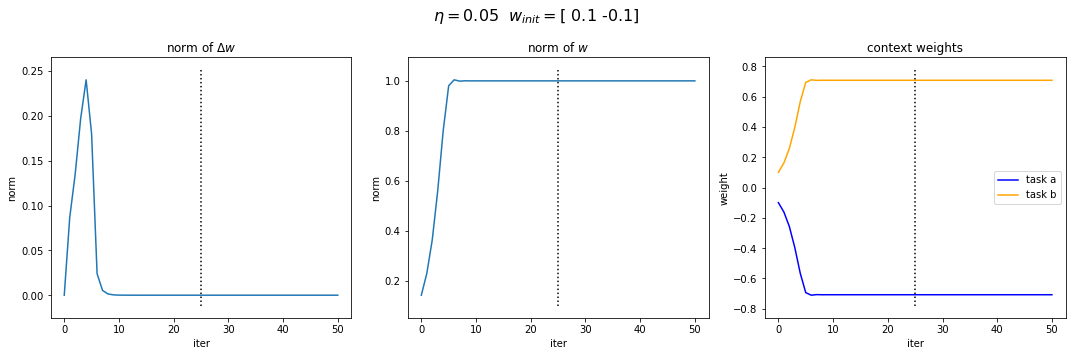

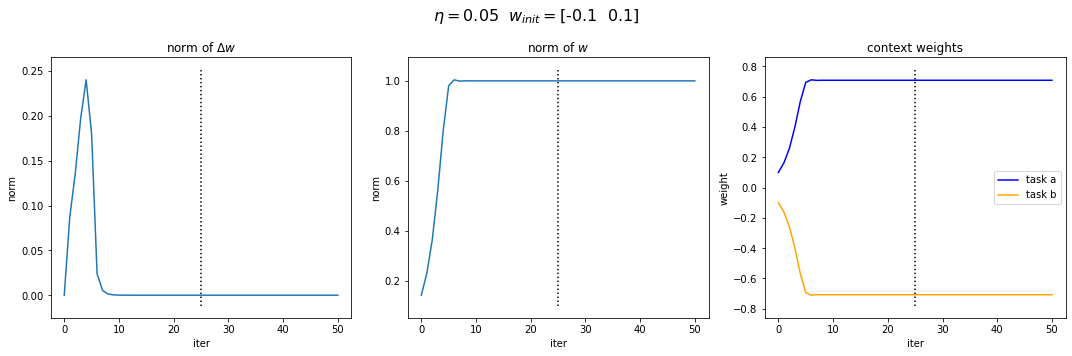

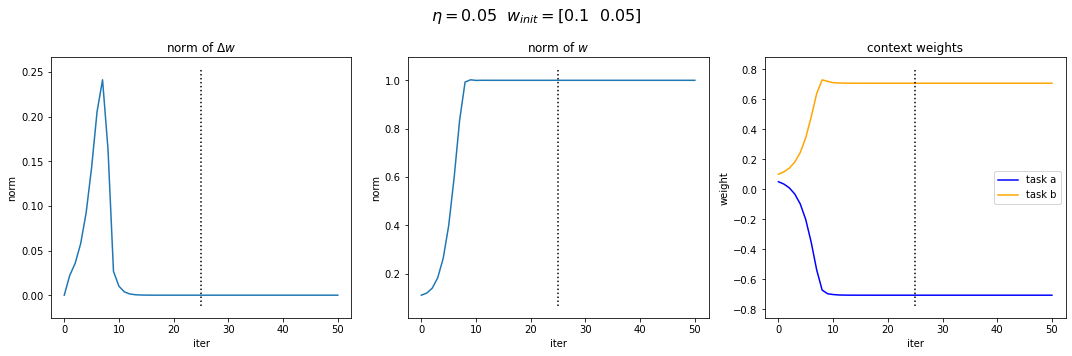

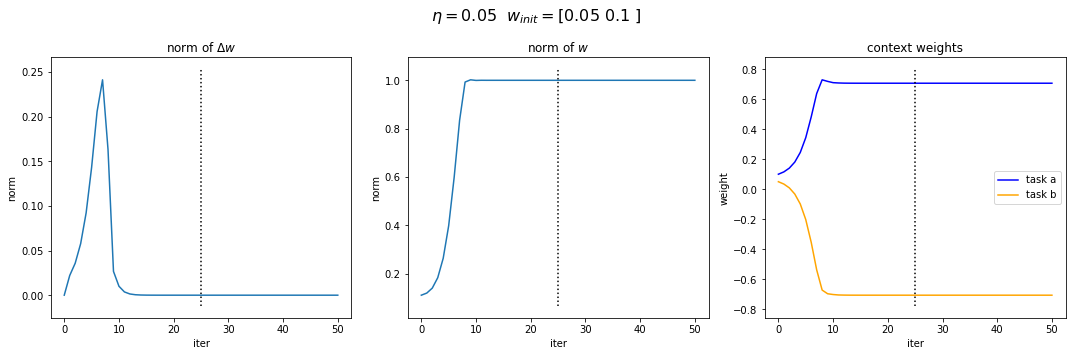

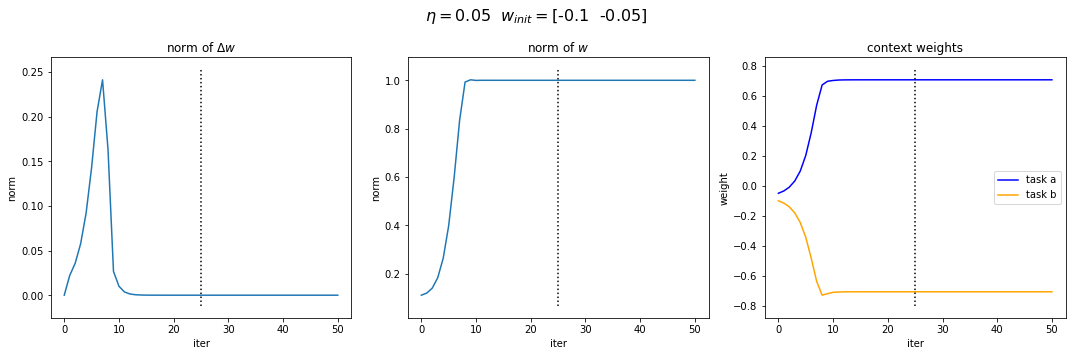

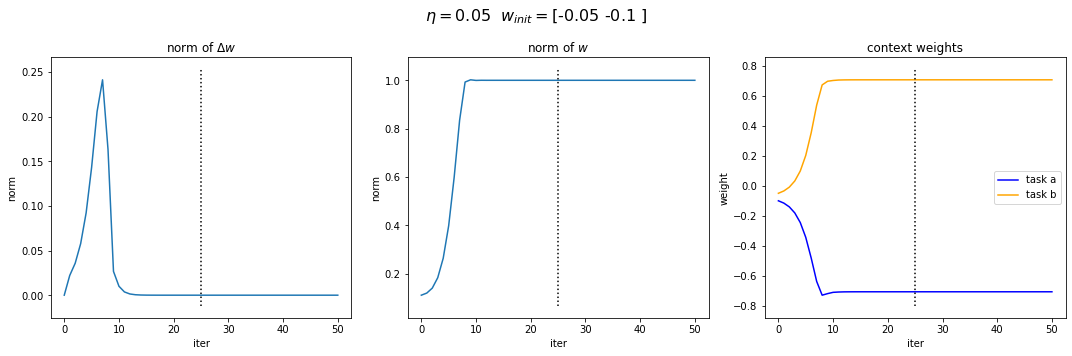

In [506]:
# TODO explore weight symmetry:
# how does this depend on initialisation?
# compare (w_c1,w_c2): (1,1), (-1,-1), (1,-1), (-1,1), (.5,1), (1,.5), (-.5,-1), (-1,-.5)
# -> relate to symmetry breaking property of large weight initialisation

w_init = np.array([[1,1],[-1,-1],[1,-1],[-1,1],[1,.5],[.5,1],[-1,-.5],[-.5,-1]]).astype('float')*1e-1
eta = 5e-2
n_episodes = 1
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=5,training_schedule='blocked',ctx_avg=False,centering=True)
for wi in w_init:
    w = deepcopy(wi)
    delta_ws = []
    ws = []
    delta_ws.append(0)
    ws.append(deepcopy(w))
    X = data['x_train'][:,-2:]
    for x in X:
        y = w.T@x    
        dw = eta*y*(x-y*w.T)    
        w += dw
        delta_ws.append(dw)
        ws.append(deepcopy(w))
    plot_initsign_results(wi)



#### How do the results depend on weight scale
Larger weights -> more symmetry breaking -> earlier factorisation? 

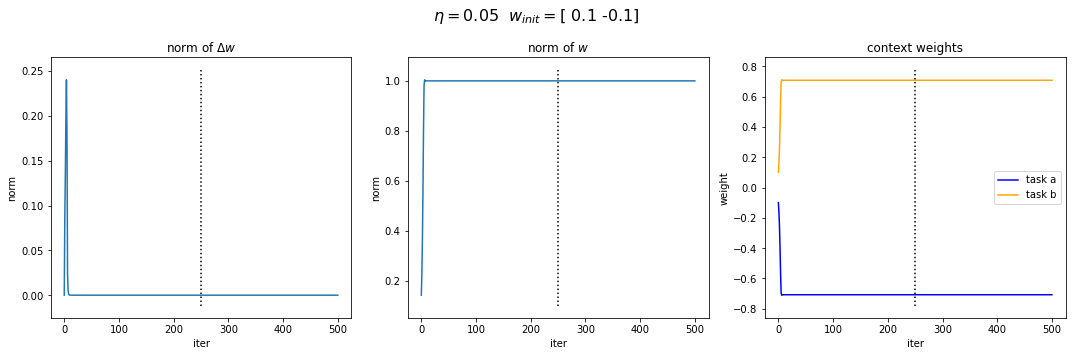

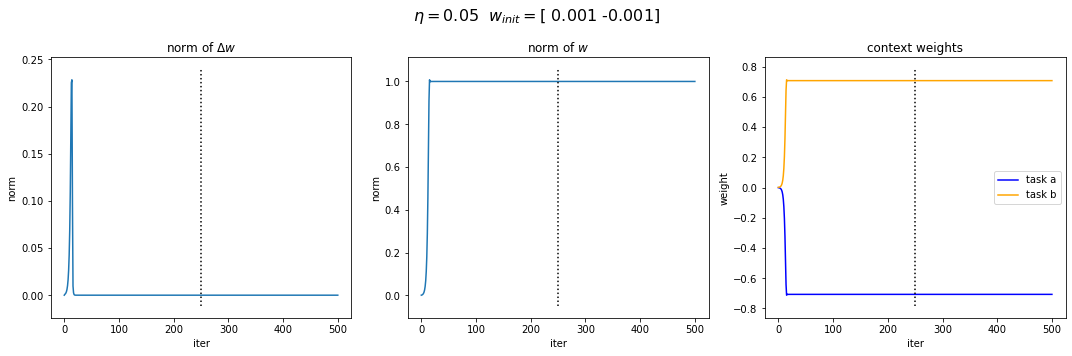

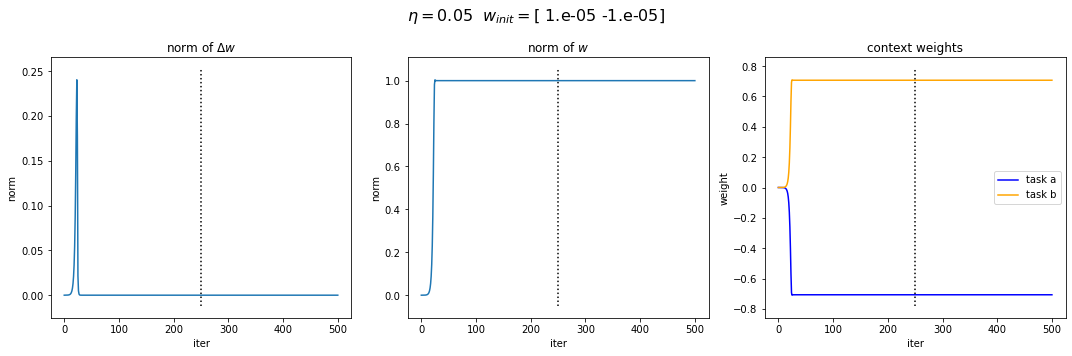

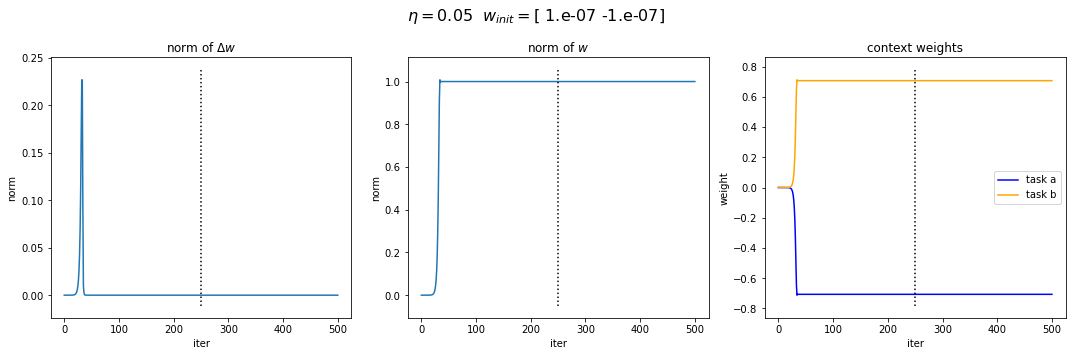

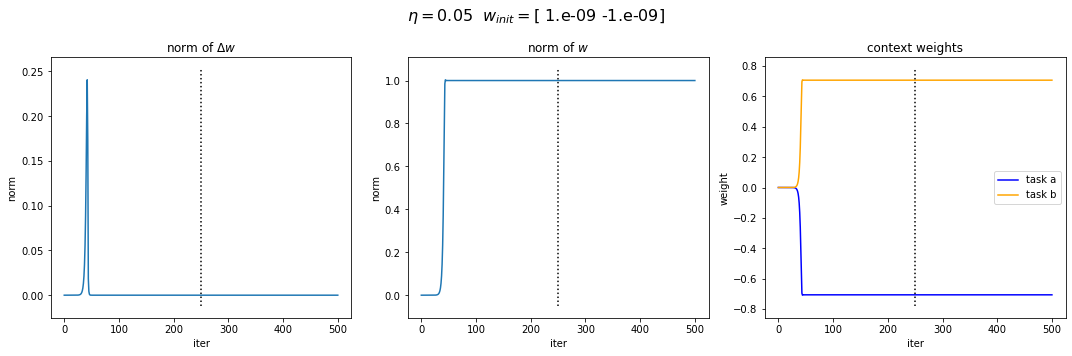

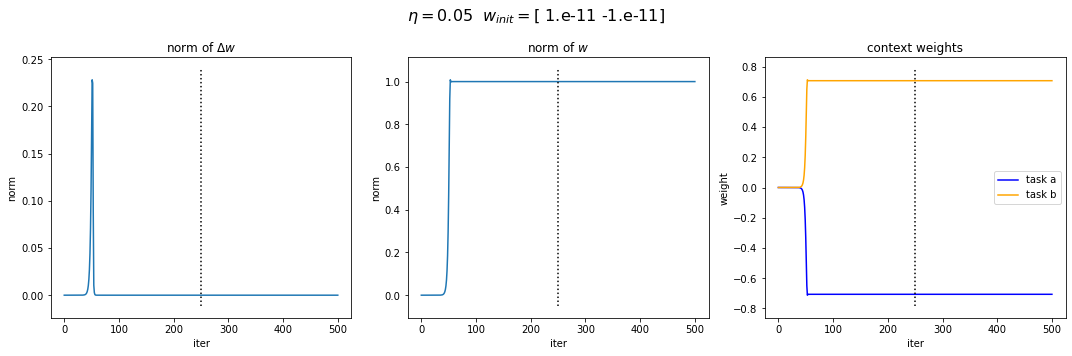

In [9]:
w_init = np.array([[10**(-i),-10**(-i)] for i in range(1,12,2)])
eta = 5e-2
n_episodes = 10
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=5,training_schedule='blocked',ctx_avg=False,centering=True)
for wi in w_init:
    w = deepcopy(wi)
    delta_ws = []
    ws = []
    delta_ws.append(0)
    ws.append(deepcopy(w))
    X = data['x_train'][:,-2:]
    for x in X:
        y = w.T@x    
        dw = eta*y*(x-y*w.T)    
        w += dw
        delta_ws.append(dw)
        ws.append(deepcopy(w))
    plot_initsign_results(wi)

#### How do the results depend on centering
one-hot vs centered.. (Note: with ctx_scaling=2 I get anti-correlated but very small weights for small init weights, but leave this aside for now. would be too small to turn hidden units on/off)

In [8]:
X

array([[5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [5., 0.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.],
       [0., 5.]])

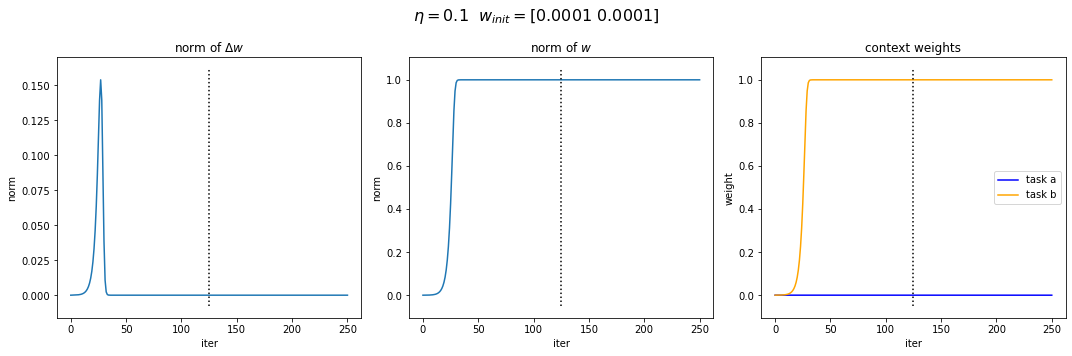

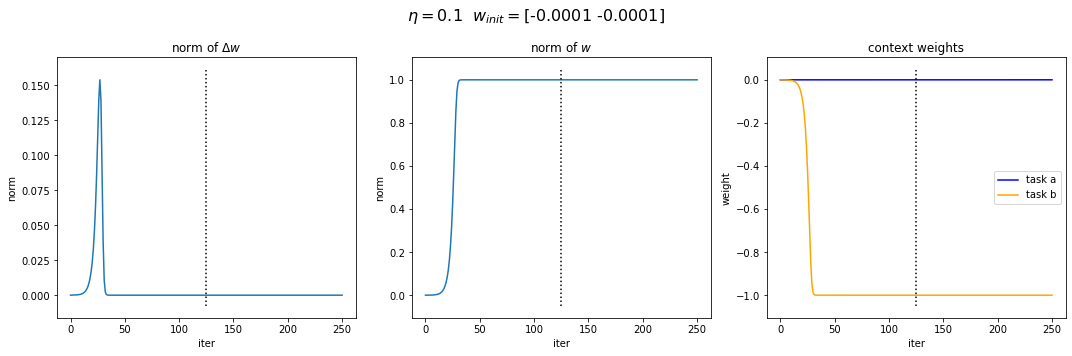

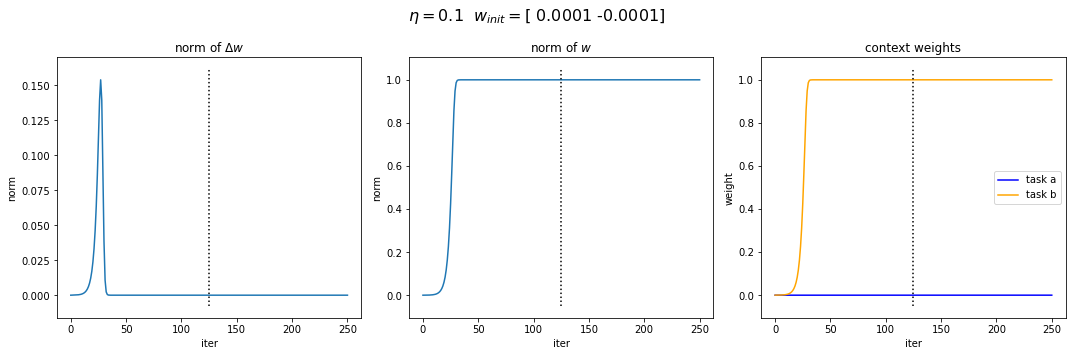

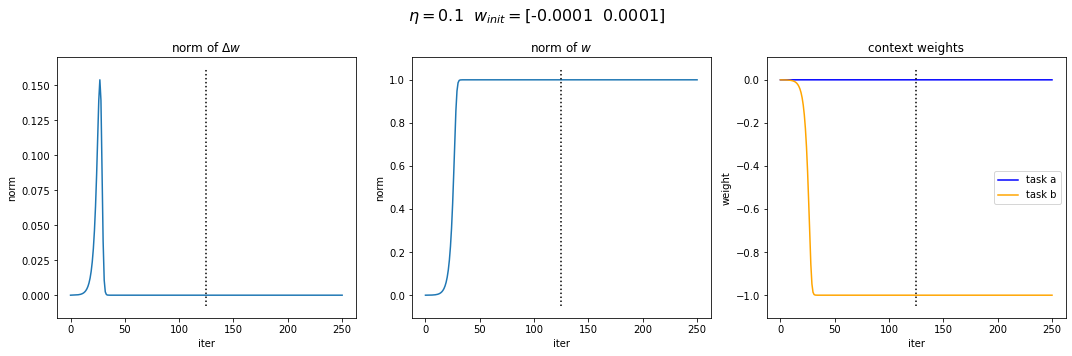

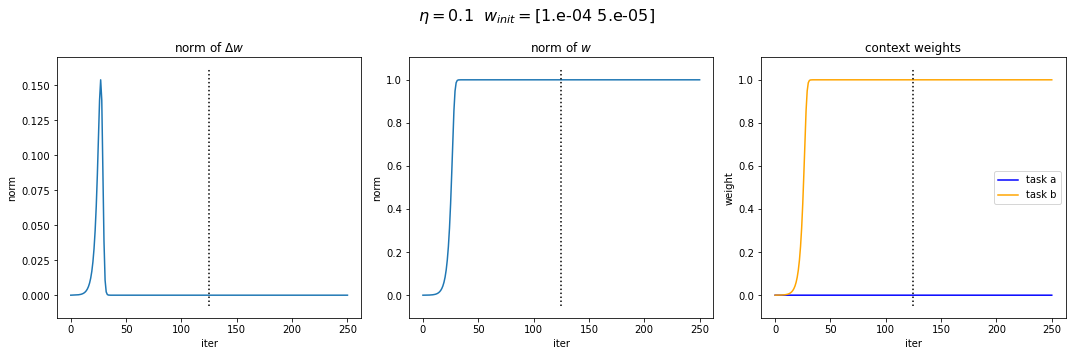

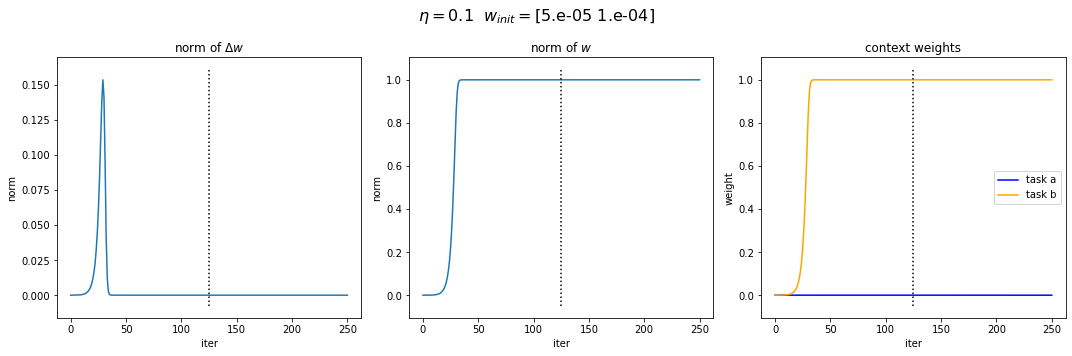

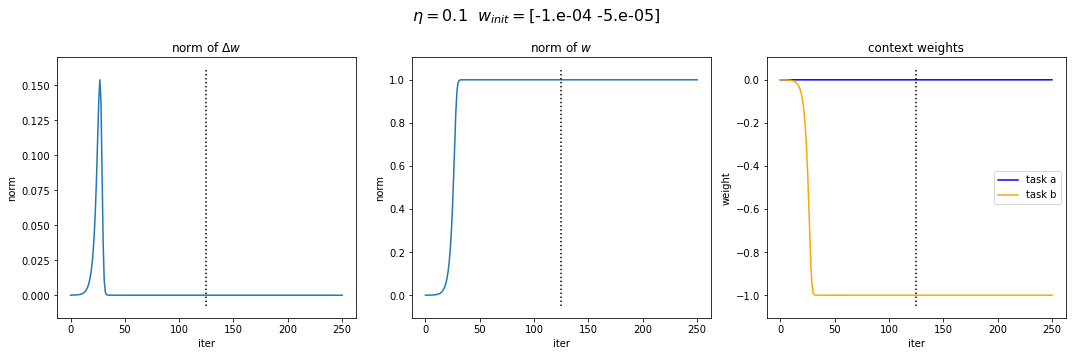

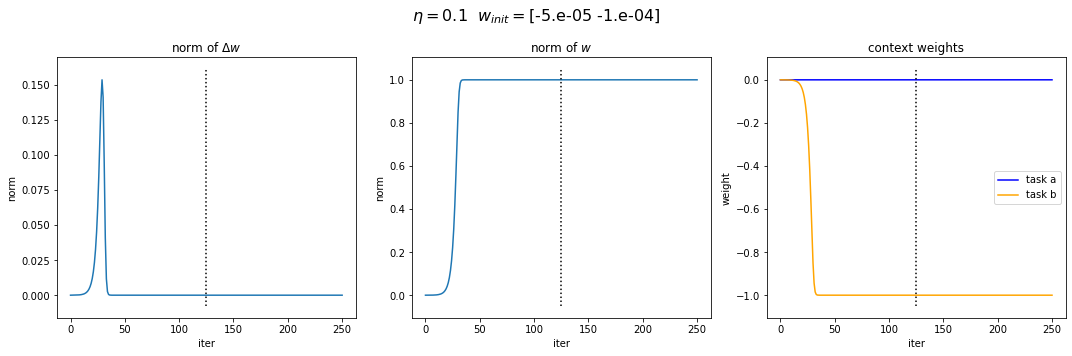

In [21]:
# TODO explore weight symmetry:
# how does this depend on initialisation?
# compare (w_c1,w_c2): (1,1), (-1,-1), (1,-1), (-1,1), (.5,1), (1,.5), (-.5,-1), (-1,-.5)
# -> relate to symmetry breaking property of large weight initialisation

w_init = np.array([[1,1],[-1,-1],[1,-1],[-1,1],[1,.5],[.5,1],[-1,-.5],[-.5,-1]]).astype('float')*1e-4
eta = 1e-1
n_episodes = 5
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=2,training_schedule='blocked',ctx_avg=False,centering=False)
for wi in w_init:
    w = deepcopy(wi)
    delta_ws = []
    ws = []
    delta_ws.append(0)
    ws.append(deepcopy(w))
    X = data['x_train'][:,-2:]
    for x in X:
        y = w.T@x    
        dw = eta*y*(x-y*w.T)    
        w += dw
        delta_ws.append(dw)
        ws.append(deepcopy(w))
    plot_initsign_results(wi)



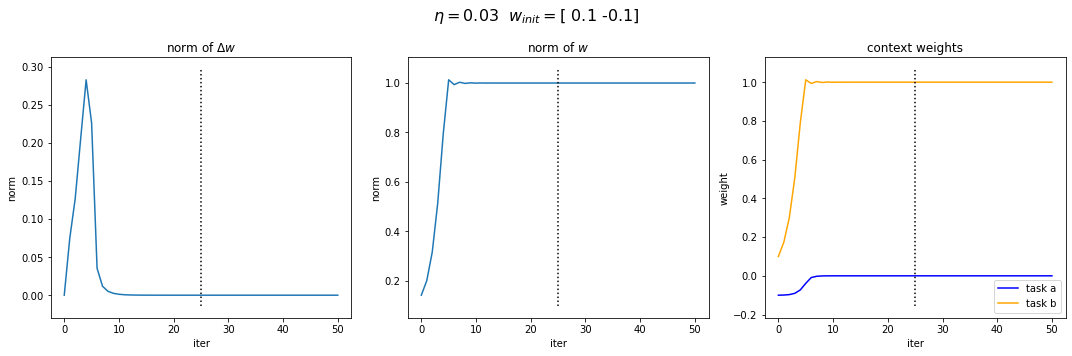

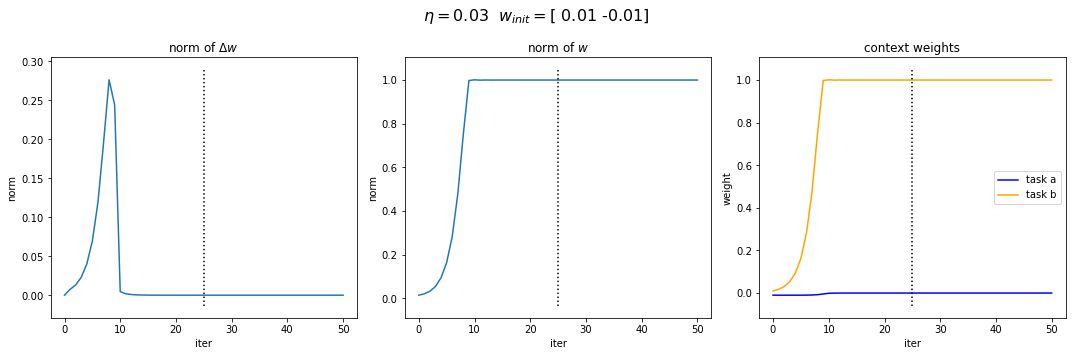

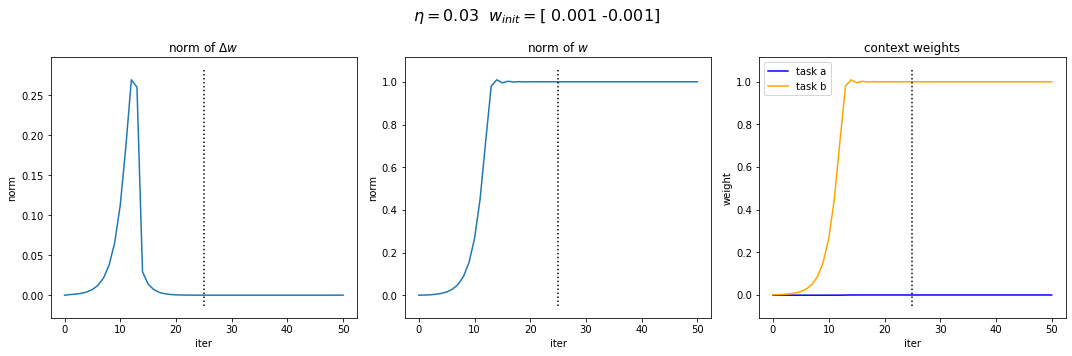

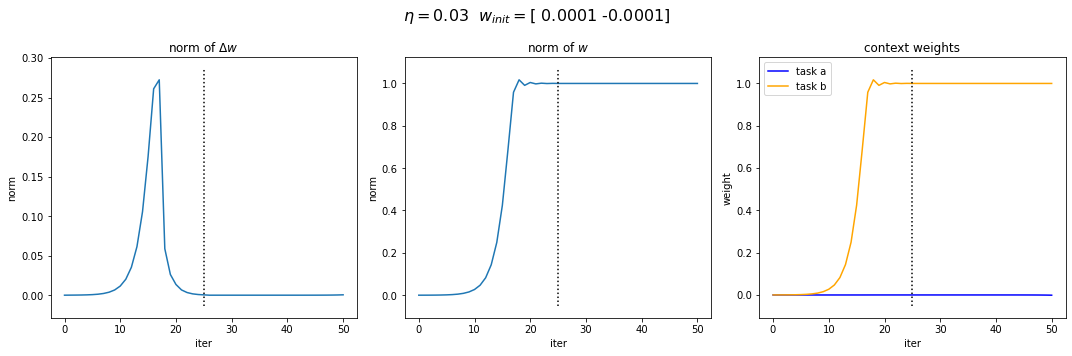

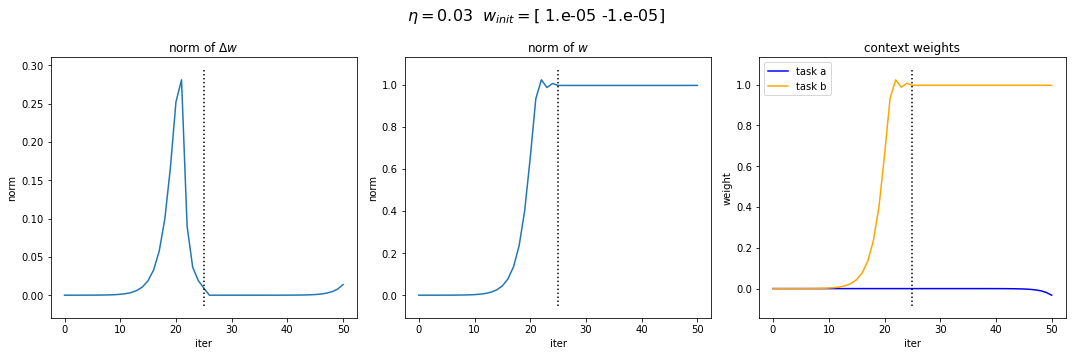

In [126]:
w_init = np.array([[10**(-i),-10**(-i)] for i in range(1,6,1)])
eta = 3e-2
n_episodes = 1
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=5,training_schedule='blocked',ctx_avg=False,centering=False)
for wi in w_init:
    w = deepcopy(wi)
    delta_ws = []
    ws = []
    delta_ws.append(0)
    ws.append(deepcopy(w))
    X = data['x_train'][:,-2:]
    for x in X:
        y = w.T@x    
        dw = eta*y*(x-y*w.T)    
        w += dw
        delta_ws.append(dw)
        ws.append(deepcopy(w))
    plot_initsign_results(wi)

 what happens when we reduce the ctx scaling? (note: this no longer works when I train on the entire dataset)

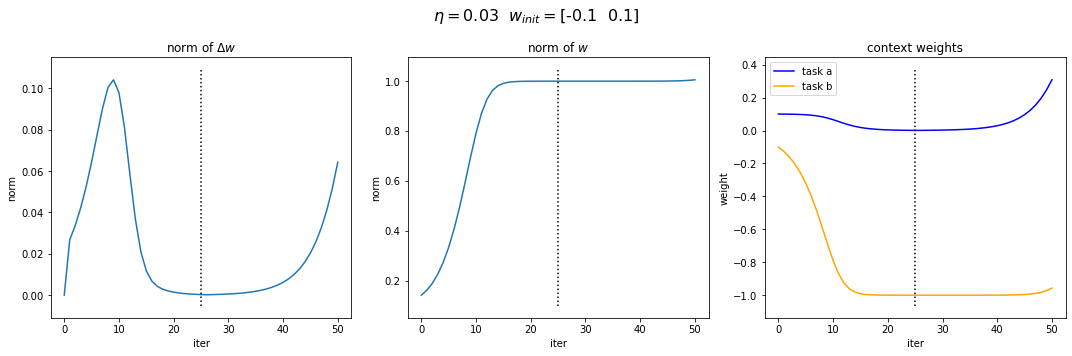

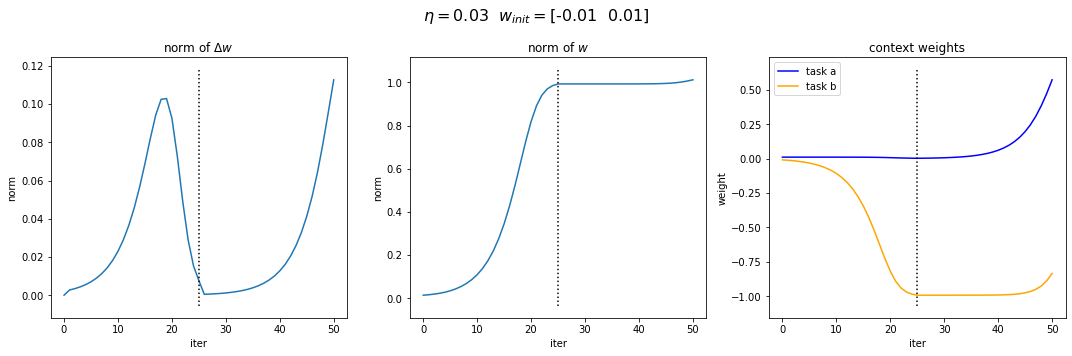

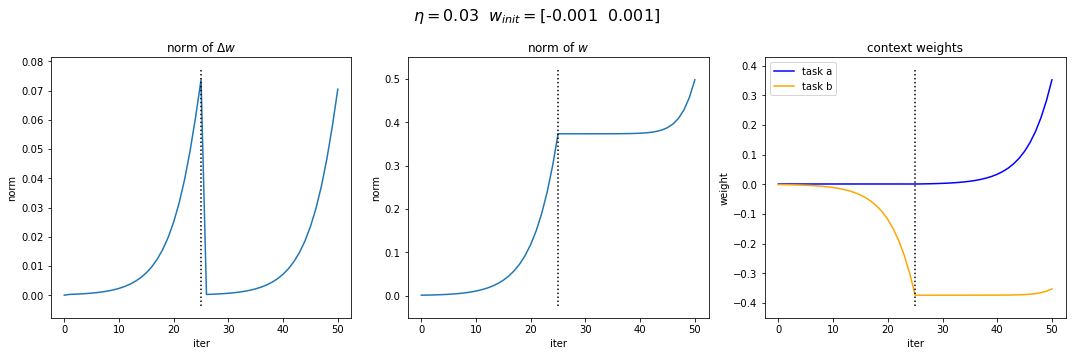

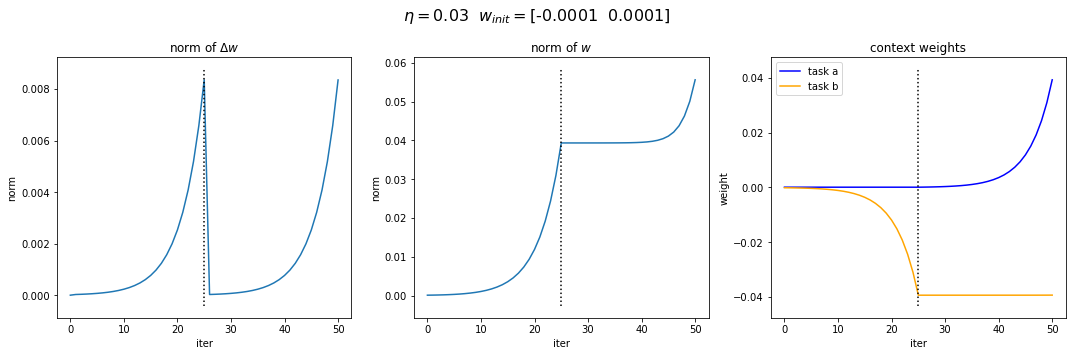

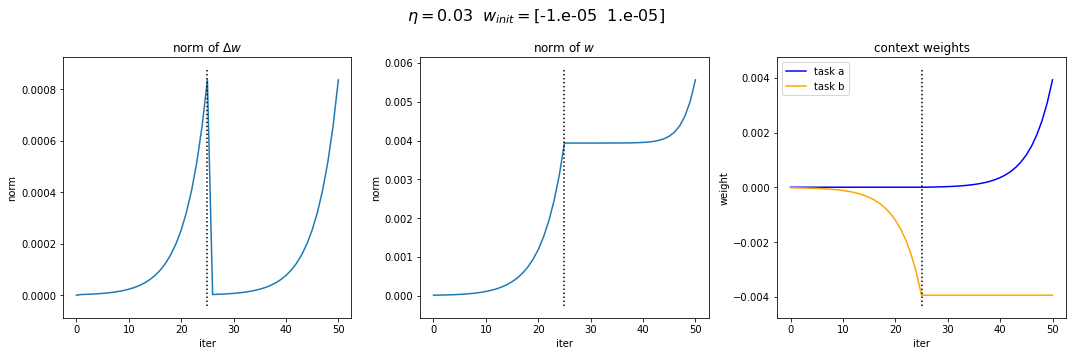

In [13]:
w_init = np.array([[-10**(-i),10**(-i)] for i in range(1,6,1)])
eta = 3e-2
n_episodes = 1
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=3,training_schedule='blocked',ctx_avg=False,centering=False)
for wi in w_init:
    w = deepcopy(wi)
    delta_ws = []
    ws = []
    delta_ws.append(0)
    ws.append(deepcopy(w))
    X = data['x_train'][:,-2:]
    for x in X:
        y = w.T@x    
        dw = eta*y*(x-y*w.T)    
        w += dw
        delta_ws.append(dw)
        ws.append(deepcopy(w))
    plot_initsign_results(wi)

### Generalised Hebbian Learning
So far, we've focused on learning the associations between context units and a single hidden unit. However, there are more directions of variance in the data. Let's add more hidden units and see if we can recover the first n PCs that would be found with PCA. 
Once again, explore how timecourse depend on   

    a) (sign of weights at init)
    b) init weight scale
    c) context scale ?
    
The GHA extends Oja's rule to multiple units by adding Gram-Schmidt Orthogonalisation, so that each hidden unit learns a separate principal component: 
$$ \Delta \textbf{W} = \eta \left[ \textbf{y} \circ \textbf{x} - tril(\textbf{y} \circ \textbf{y})\textbf{W}^T\right]$$

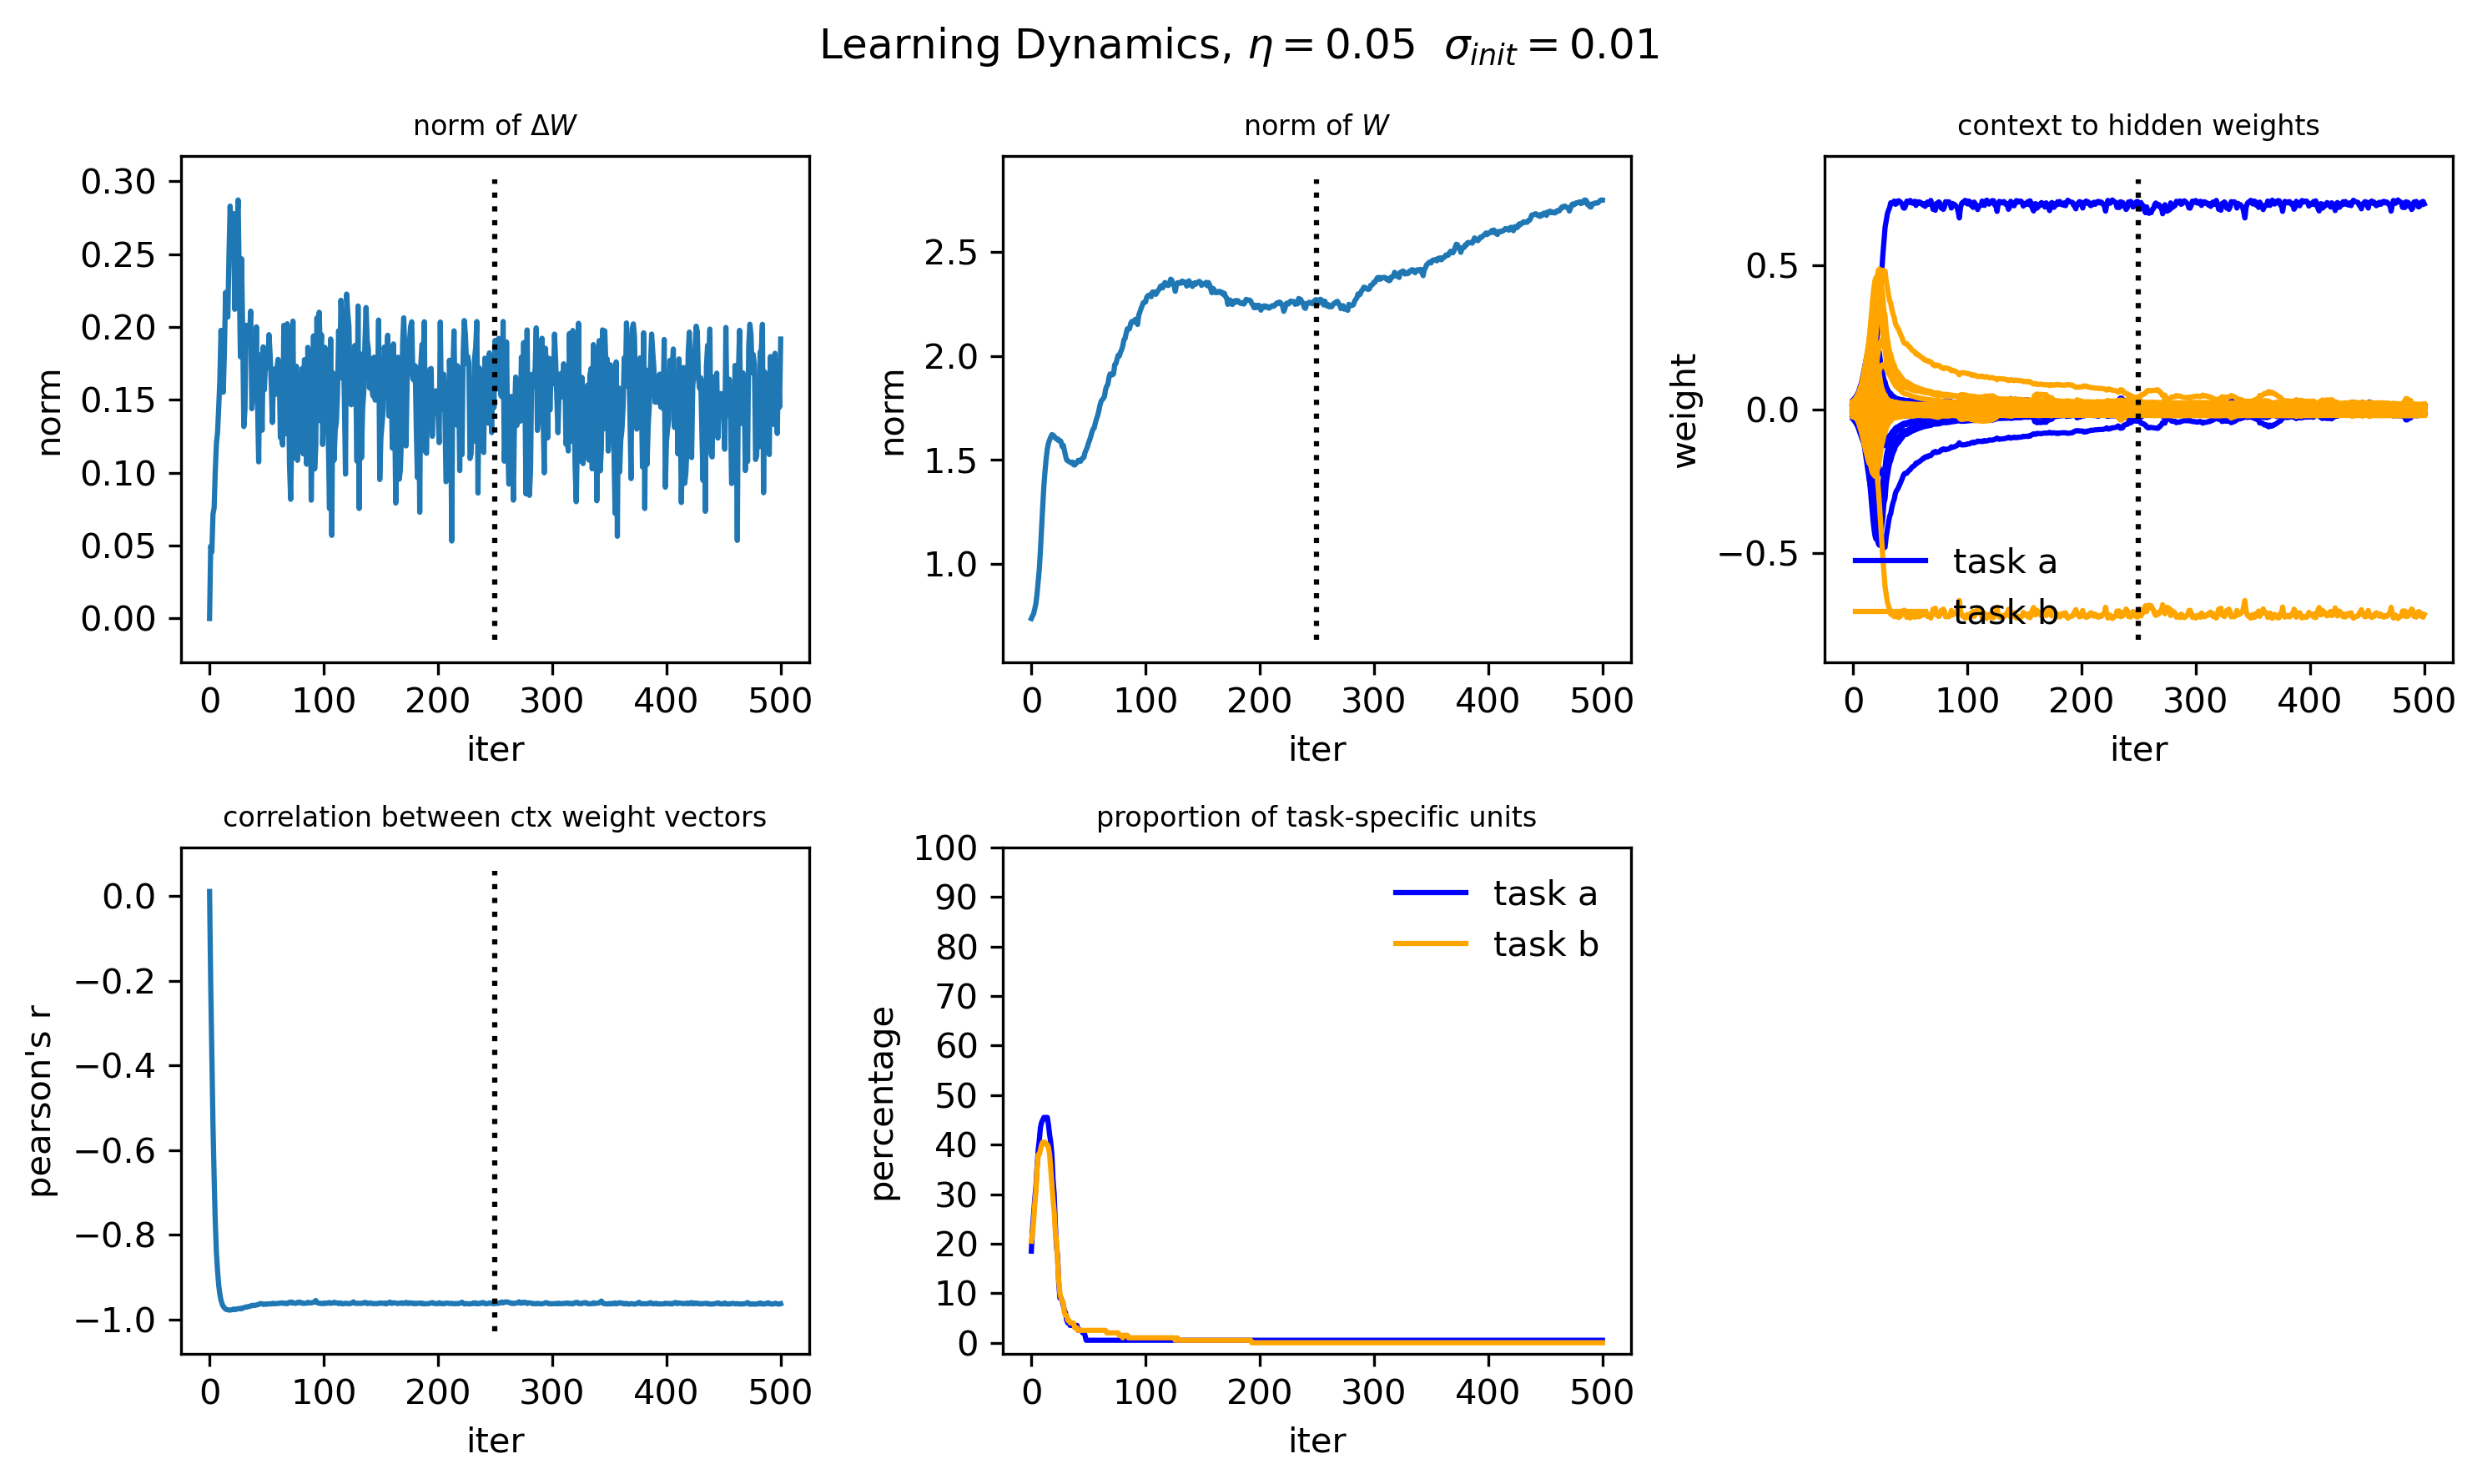

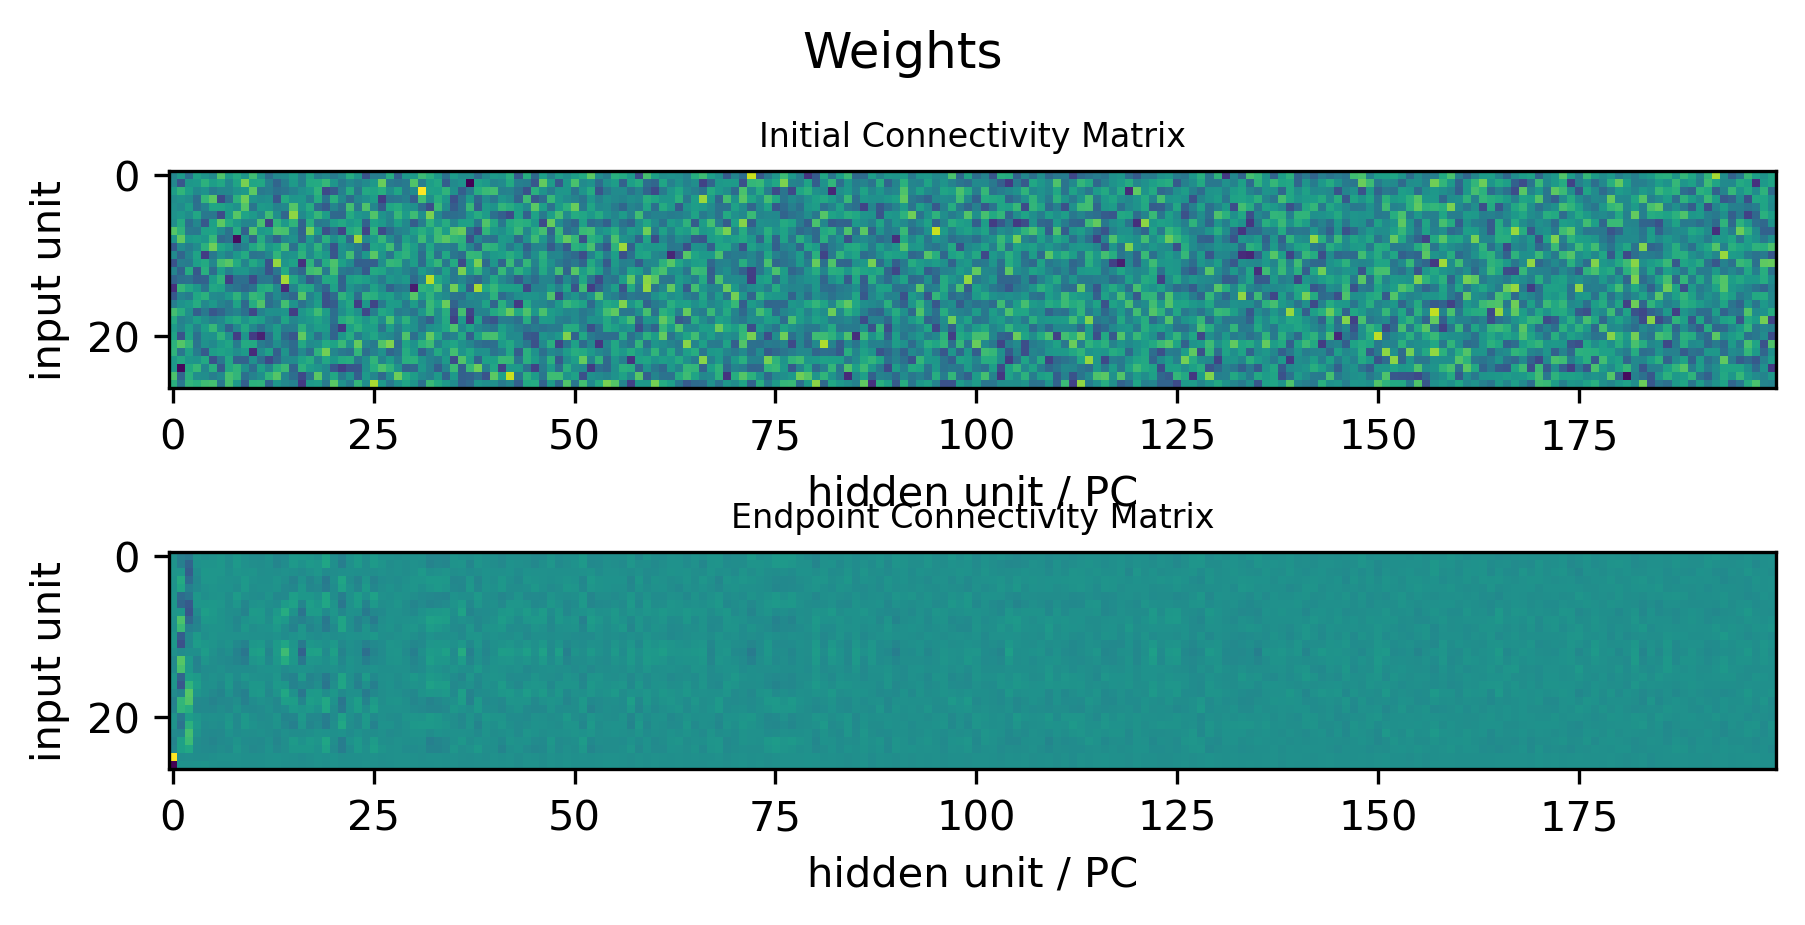

In [7]:
# now with GHA
from copy import deepcopy
eta = 5e-2
sigma = 1e-2
n_hidden = 200
n_episodes = 10
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=3,training_schedule='blocked',ctx_avg=False,centering=True)
W = np.random.randn(27,n_hidden)*sigma
delta_ws = []
ws = []
delta_ws.append(0)
ws.append(deepcopy(W))
X = data['x_train']
for x in X:
    y = W.T@x    
    dW = eta*(np.outer(y,x)-np.tril(np.outer(y,y))@W.T).T   
    W += dW
    delta_ws.append(dW)
    ws.append(deepcopy(W))
plot_ghasla_results()

### Subspace Learning Algorithm

Before training: 
 task A only: 0.12,task B only: 0.2
After training: 
 task A only: 0.42,task B only: 0.54


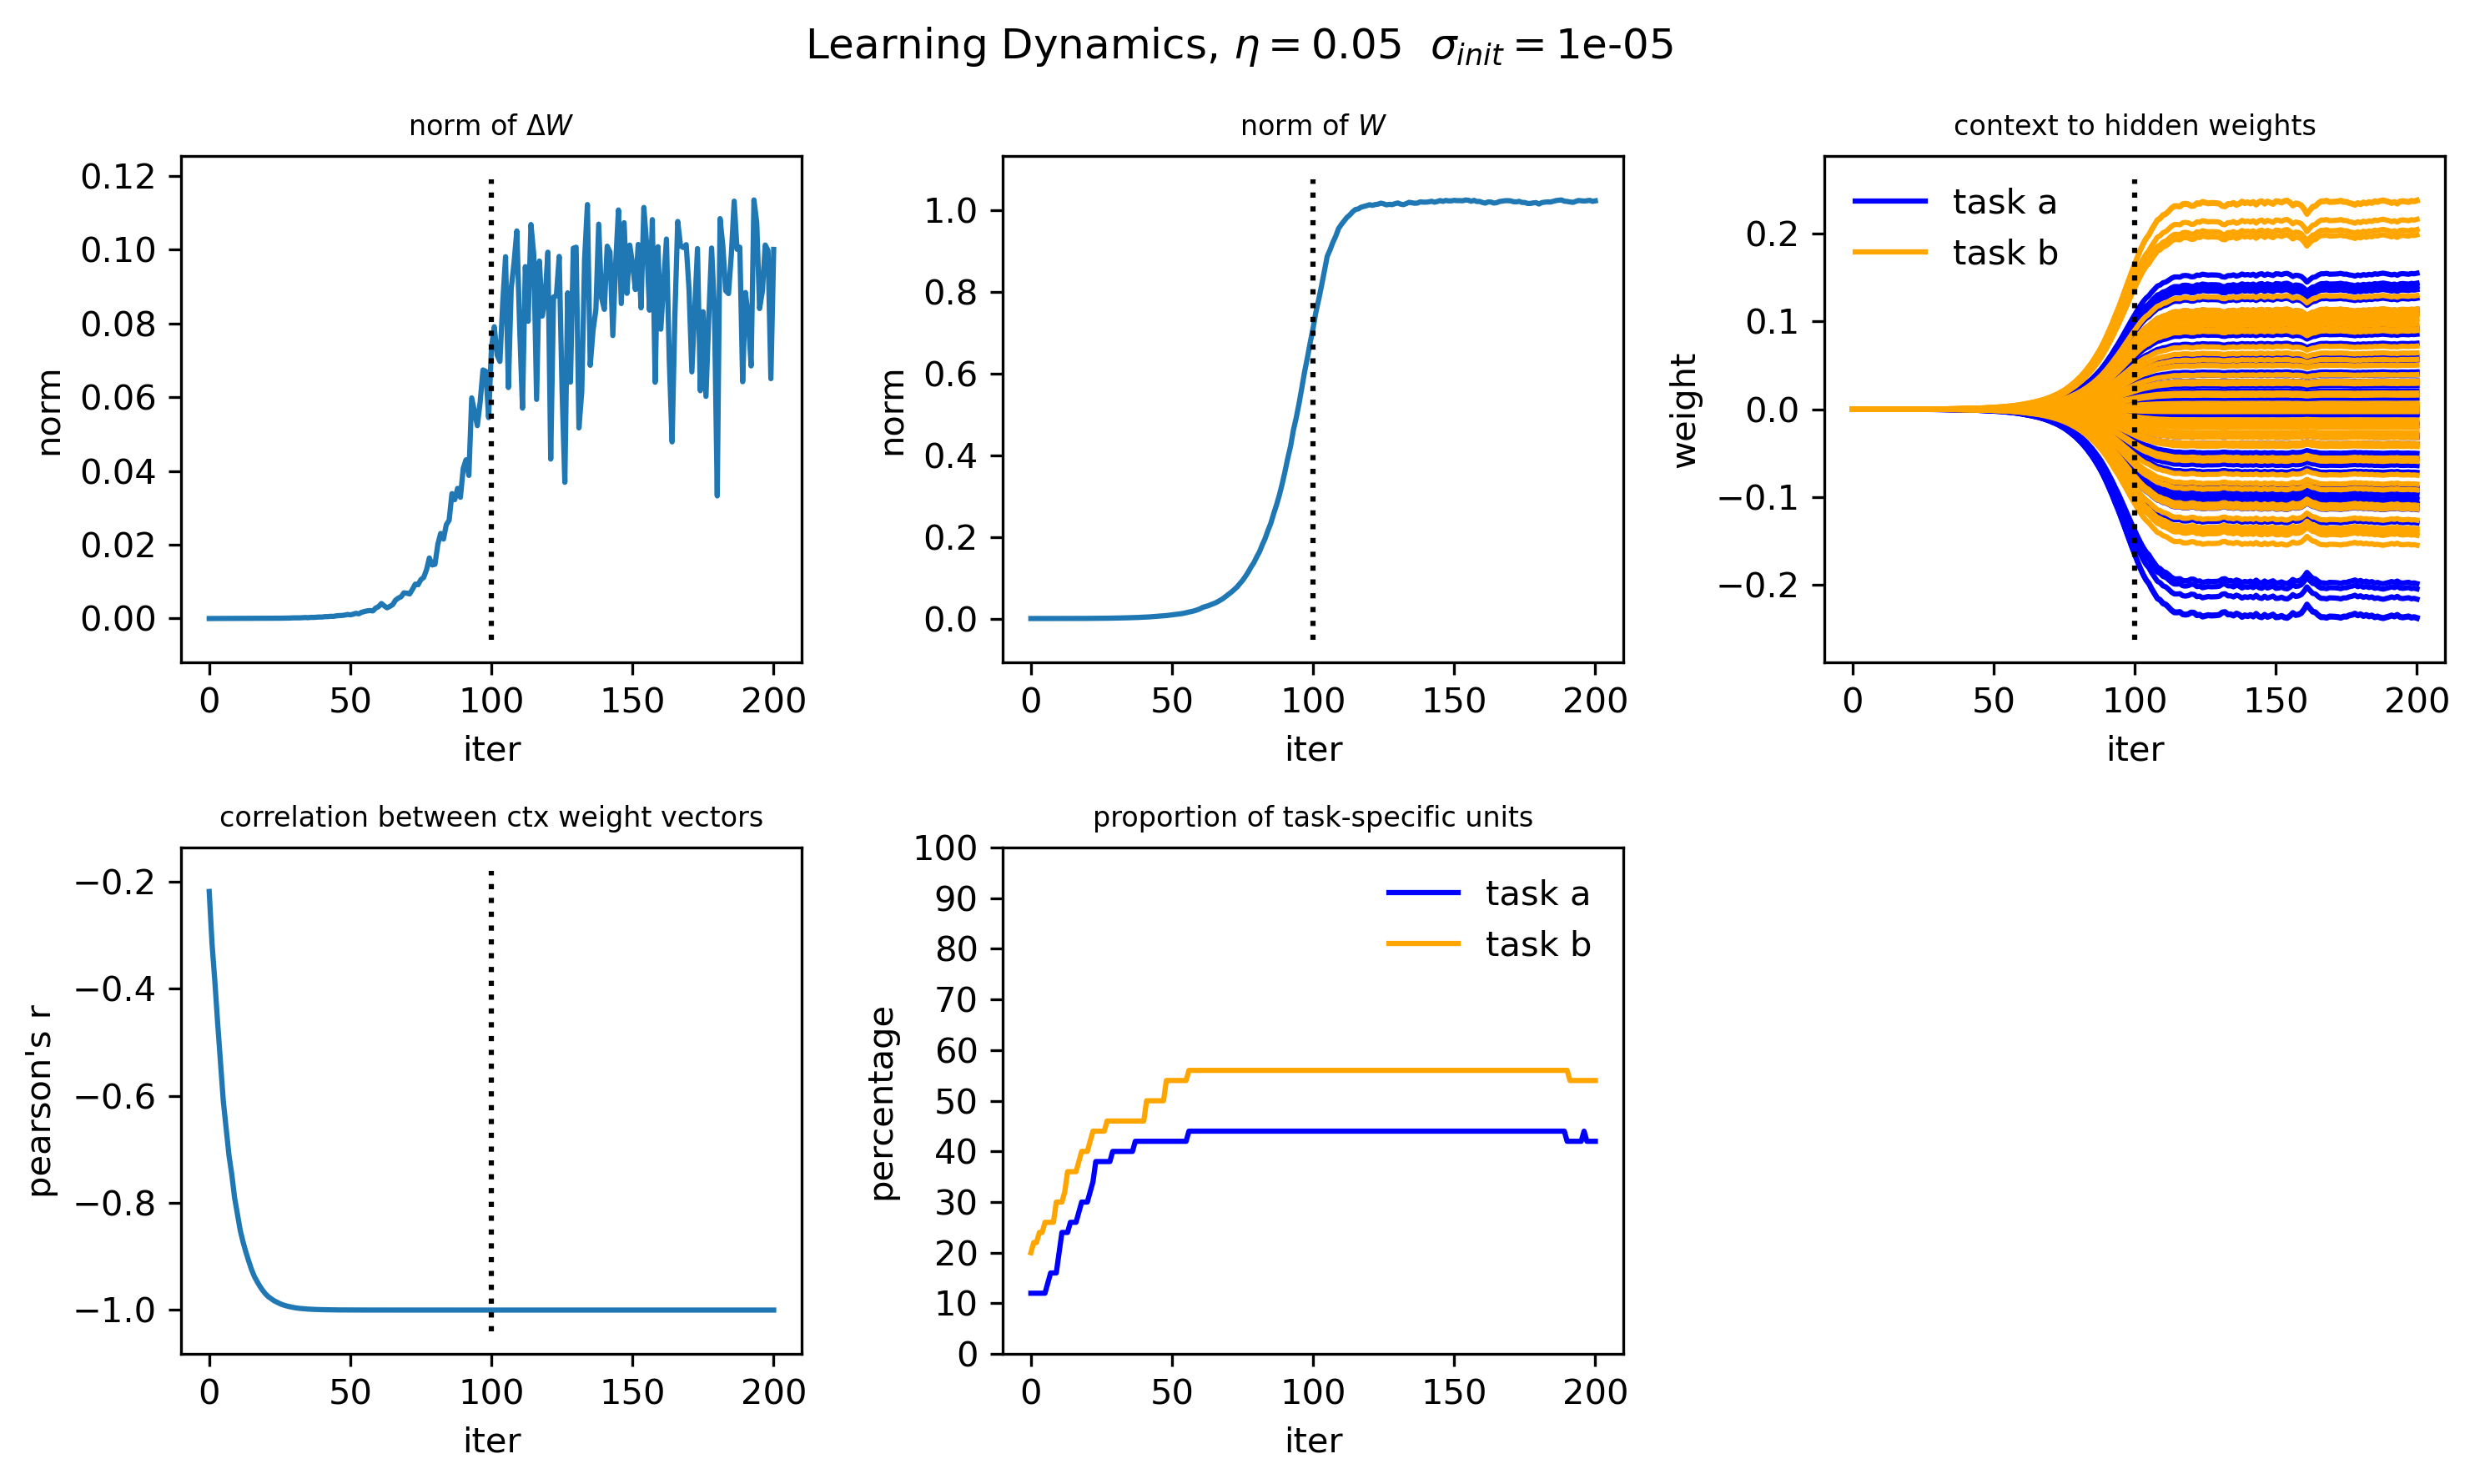

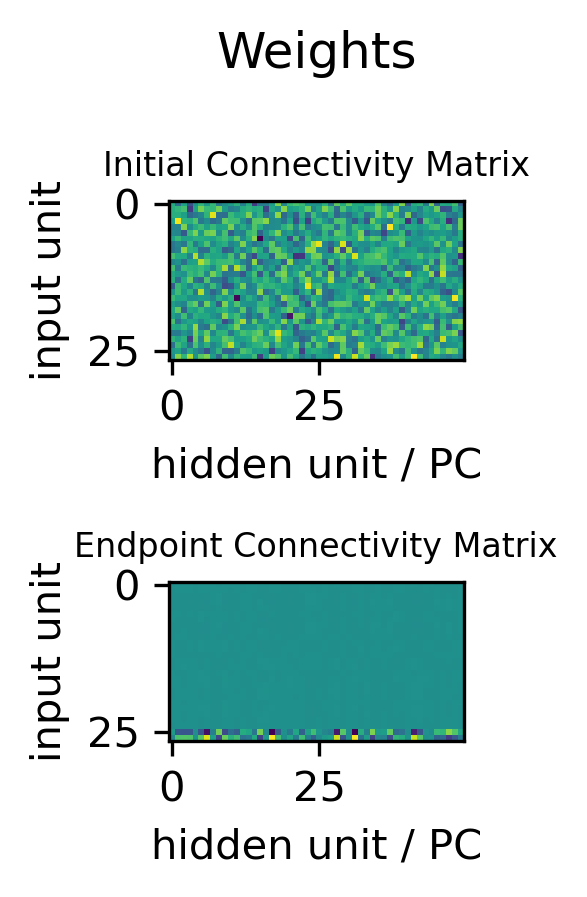

In [5]:
# now with SLA rule
eta = 5e-2
sigma = 1e-5
n_hidden = 50
n_episodes = 4
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=2,training_schedule='blocked',ctx_avg=False,centering=True)
W = np.random.randn(27,n_hidden)*sigma
delta_ws = []
ws = []
delta_ws.append(0)
ws.append(deepcopy(W))
X = data['x_train']
for x in X:
    y = W.T@x
    dW = eta*(np.outer(y,x)-np.outer(y,W@y)).T   
    W += dW
    delta_ws.append(dW)
    ws.append(deepcopy(W))
plot_ghasla_results()

W = ws[0]
ya = np.maximum((data['x_task_a']@W),0)
yb = np.maximum((data['x_task_b']@W),0)

print(f'Before training: \n task A only: {np.mean((ya.mean(0)>0) & (yb.mean(0)==0))},task B only: {np.mean((ya.mean(0)==0) & (yb.mean(0)>0))}')

W = ws[-1]
ya = np.maximum((data['x_task_a']@W),0)
yb = np.maximum((data['x_task_b']@W),0)
print(f'After training: \n task A only: {np.mean((ya.mean(0)>0) & (yb.mean(0)==0))},task B only: {np.mean((ya.mean(0)==0) & (yb.mean(0)>0))}')

In [26]:
%matplotlib qt
yh = np.maximum(data['x_all']@ws[-1],0)

f,axs = plt.subplots(5,10,figsize=(5,3),dpi=300)
axs = axs.flatten()
for i,ax in enumerate(axs):
    ax.imshow(yh[:25,i].reshape((5,5)))
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle('task a response')
plt.tight_layout()

f,axs = plt.subplots(5,10,figsize=(5,3),dpi=300)
axs = axs.flatten()    
for i,ax in enumerate(axs):
    ax.imshow(yh[25:,i].reshape((5,5)))
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle('task b response')
plt.tight_layout()



note: only centering sufficient when weight scale large, as it prepartitions the hidden layer (makes sense)
 but I can tweak hp so that SLA increases partitioning
 note how this happens already during task 1 (rationale: inhibition of neurons that are not related to the task)

### SLA with a single context unit (for sign flip)
The issue with two context units and centered data is leakage of information about the second task: the ctx inputs are 1,-1 and -1,1 (for the first and second task respectively), instead of 1,0 and 0,1. Semantically, this means "perform the first and not the second task", which only makes sense if the network knows a priori how many tasks to perform. True continual learning lacks this information.
For now, try to fix this by having only one context unit, which performs a sign flip between task A and B.

(500, 26)
Before training: 
 task A only: 0.145,task B only: 0.14
After training: 
 task A only: 0.445,task B only: 0.475


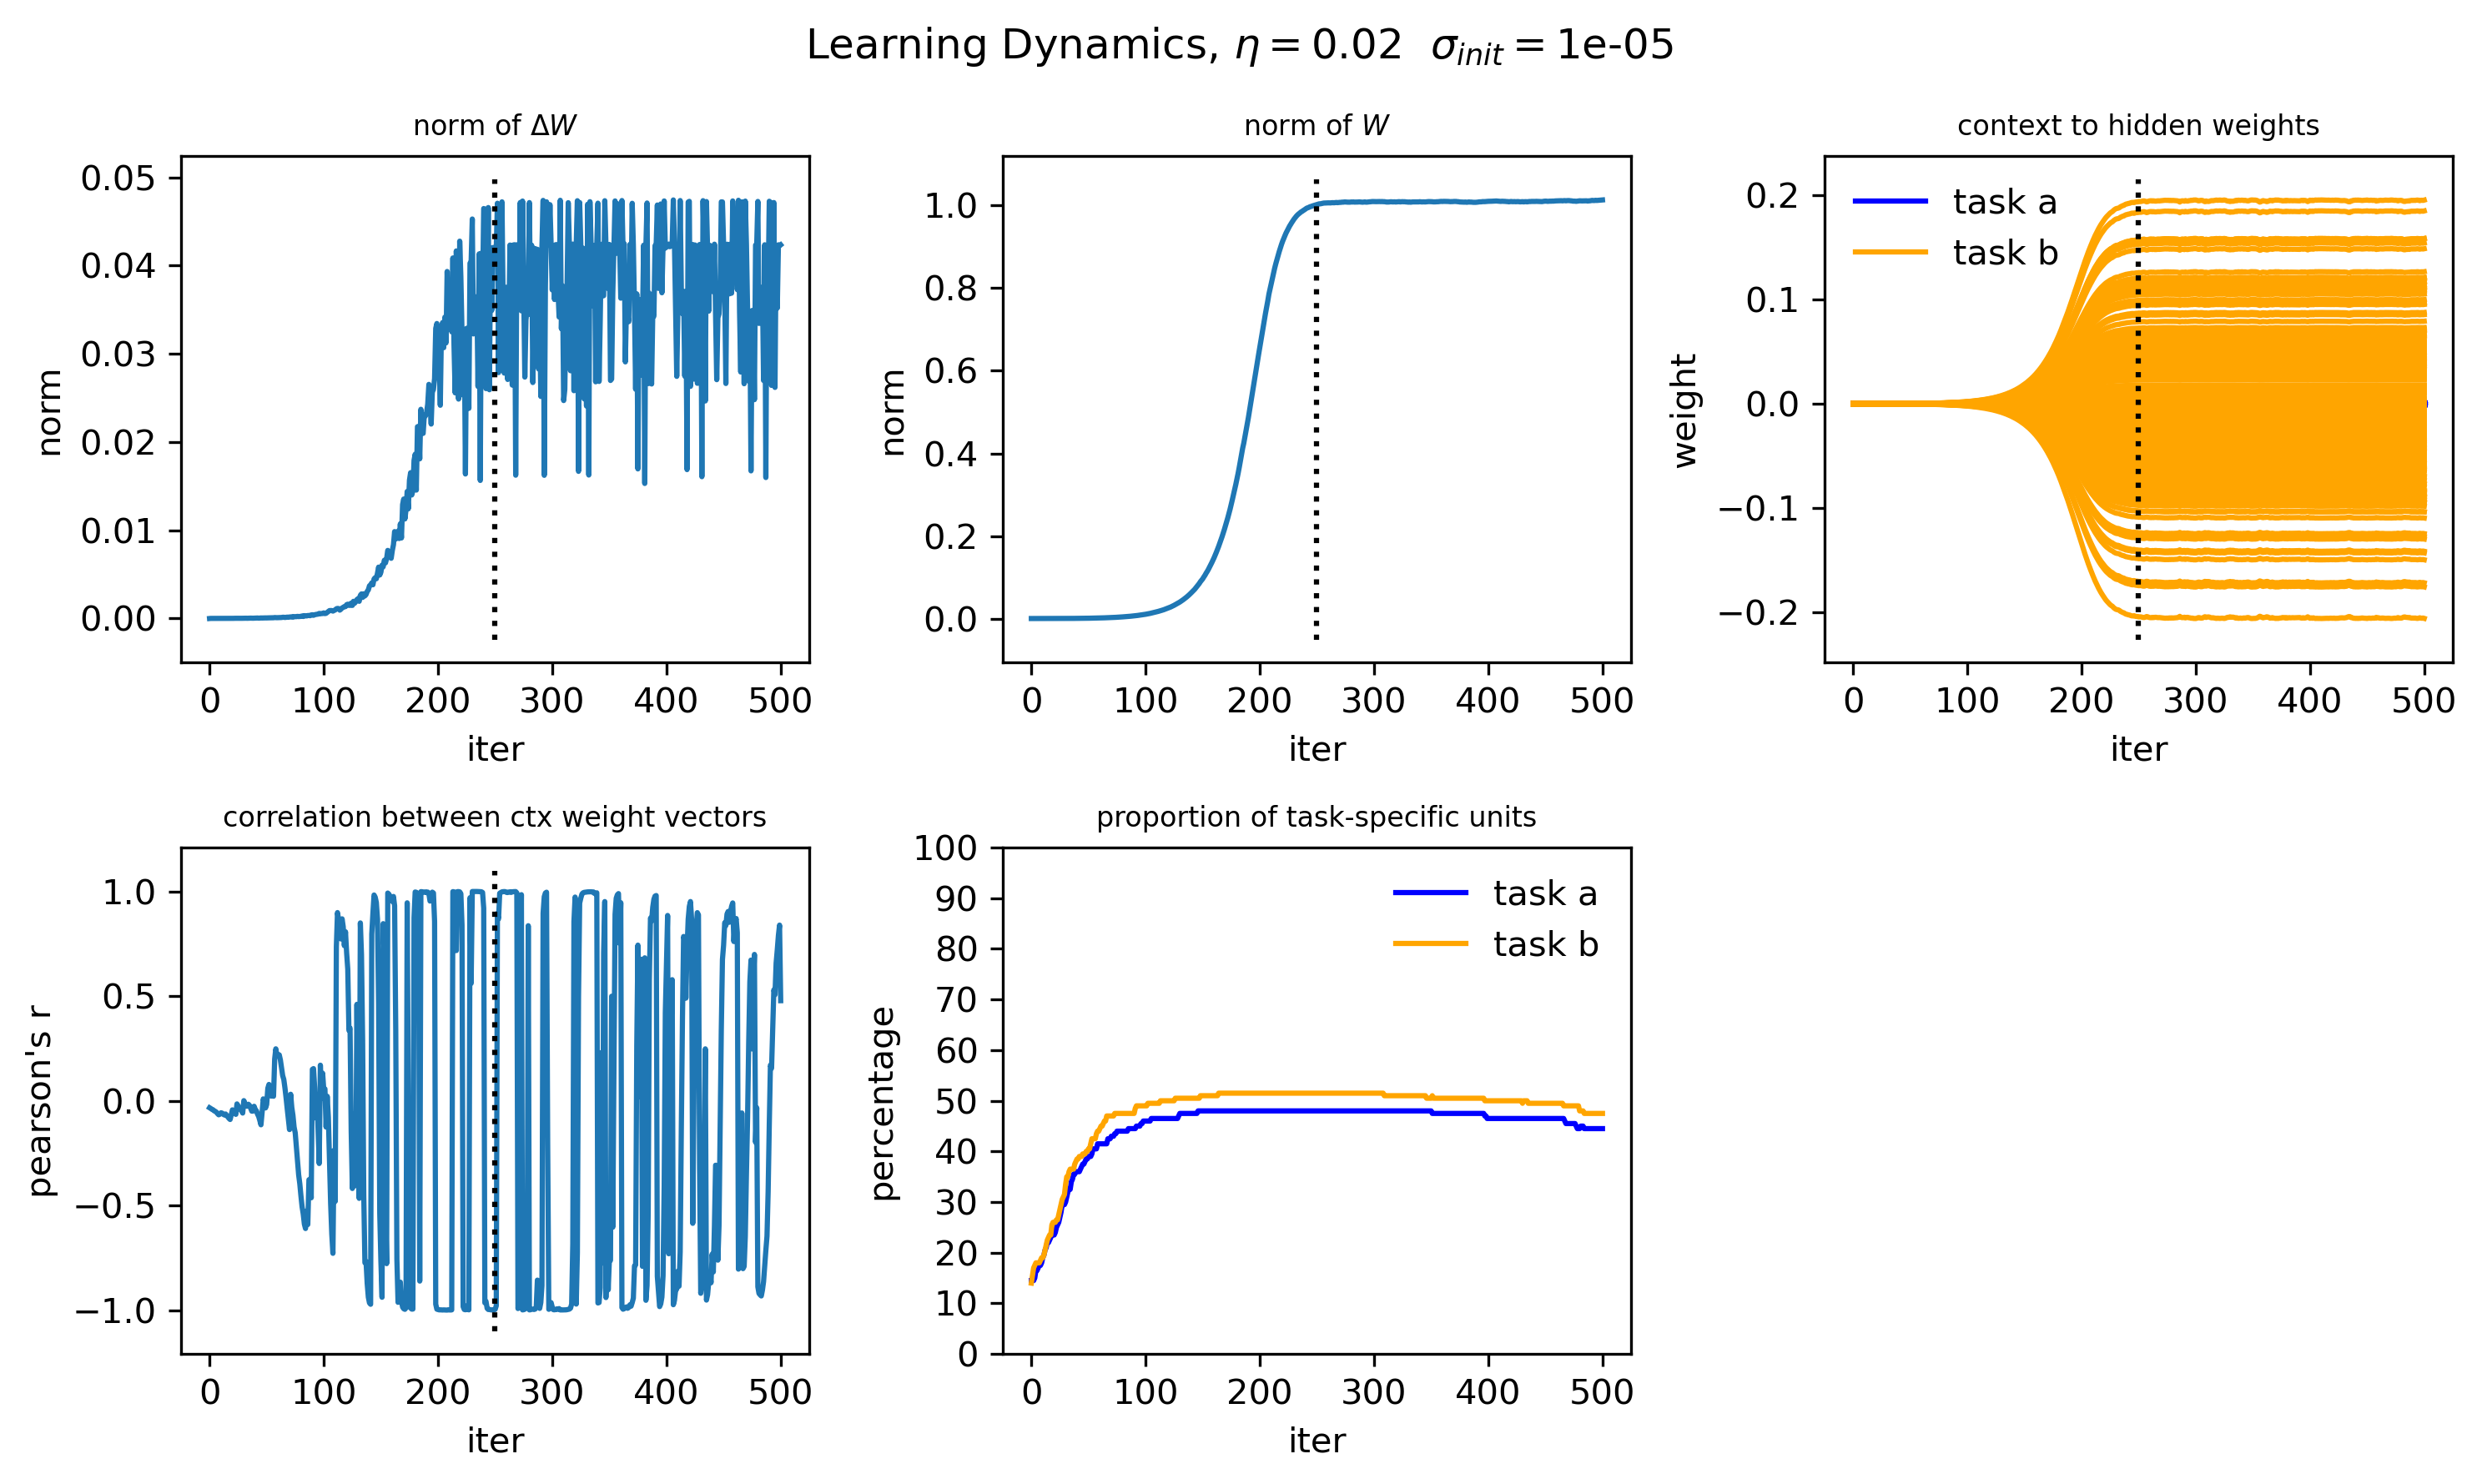

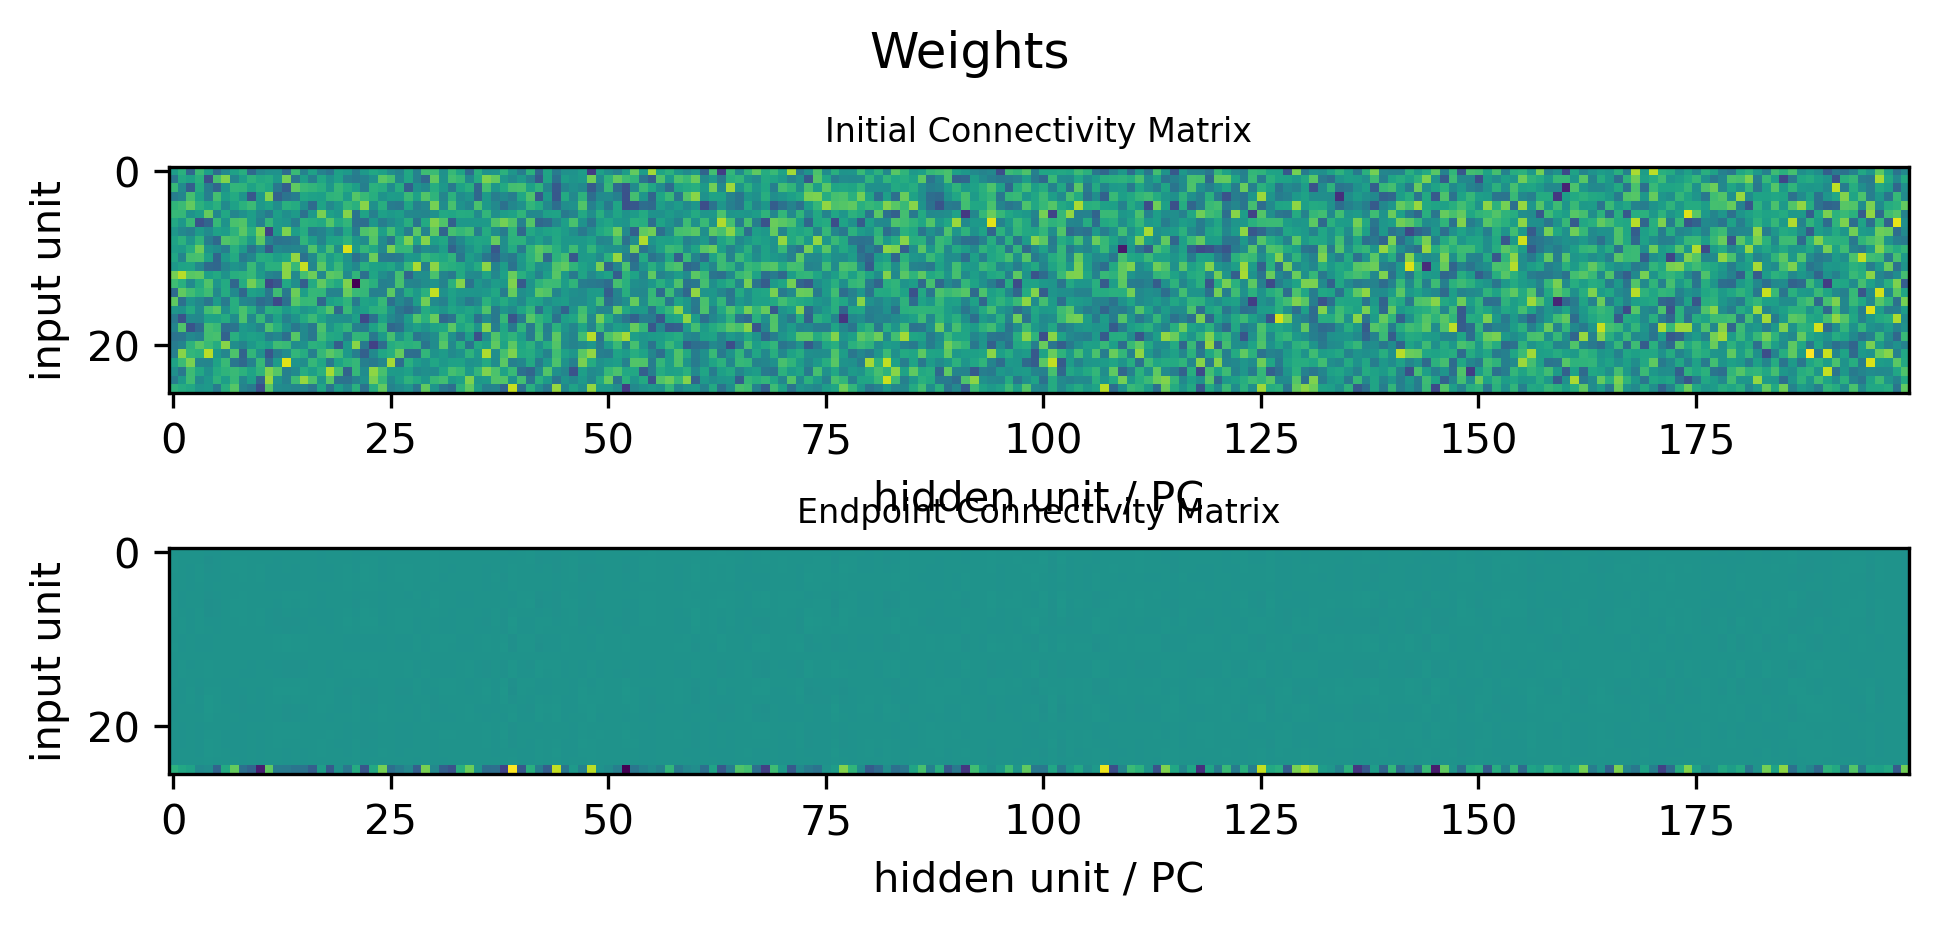

In [135]:
# now with SLA rule
eta = 2e-2
sigma = 1e-5
n_hidden = 200
n_episodes = 10
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=3,training_schedule='blocked',ctx_avg=False,centering=True)
data['x_train'] = data['x_train'][:,:-1]
print(data['x_train'].shape)
assert data['x_train'].shape[1]==26
data['x_task_a'] = data['x_task_a'][:,:-1]
data['x_task_b'] = data['x_task_b'][:,:-1]
W = np.random.randn(26,n_hidden)*sigma
delta_ws = []
ws = []
delta_ws.append(0)
ws.append(deepcopy(W))
X = data['x_train']
for x in X:
    y = W.T@x
    dW = eta*(np.outer(y,x)-np.outer(y,W@y)).T   
    W += dW
    delta_ws.append(dW)
    ws.append(deepcopy(W))
plot_ghasla_results()

W = ws[0]
ya = np.maximum((data['x_task_a']@W),0)
yb = np.maximum((data['x_task_b']@W),0)
print(f'Before training: \n task A only: {np.mean((ya.mean(0)>0) & (yb.mean(0)==0))},task B only: {np.mean((ya.mean(0)==0) & (yb.mean(0)>0))}')
W = ws[-1]
ya = np.maximum((data['x_task_a']@W),0)
yb = np.maximum((data['x_task_b']@W),0)
print(f'After training: \n task A only: {np.mean((ya.mean(0)>0) & (yb.mean(0)==0))},task B only: {np.mean((ya.mean(0)==0) & (yb.mean(0)>0))}')


# Scratchpad

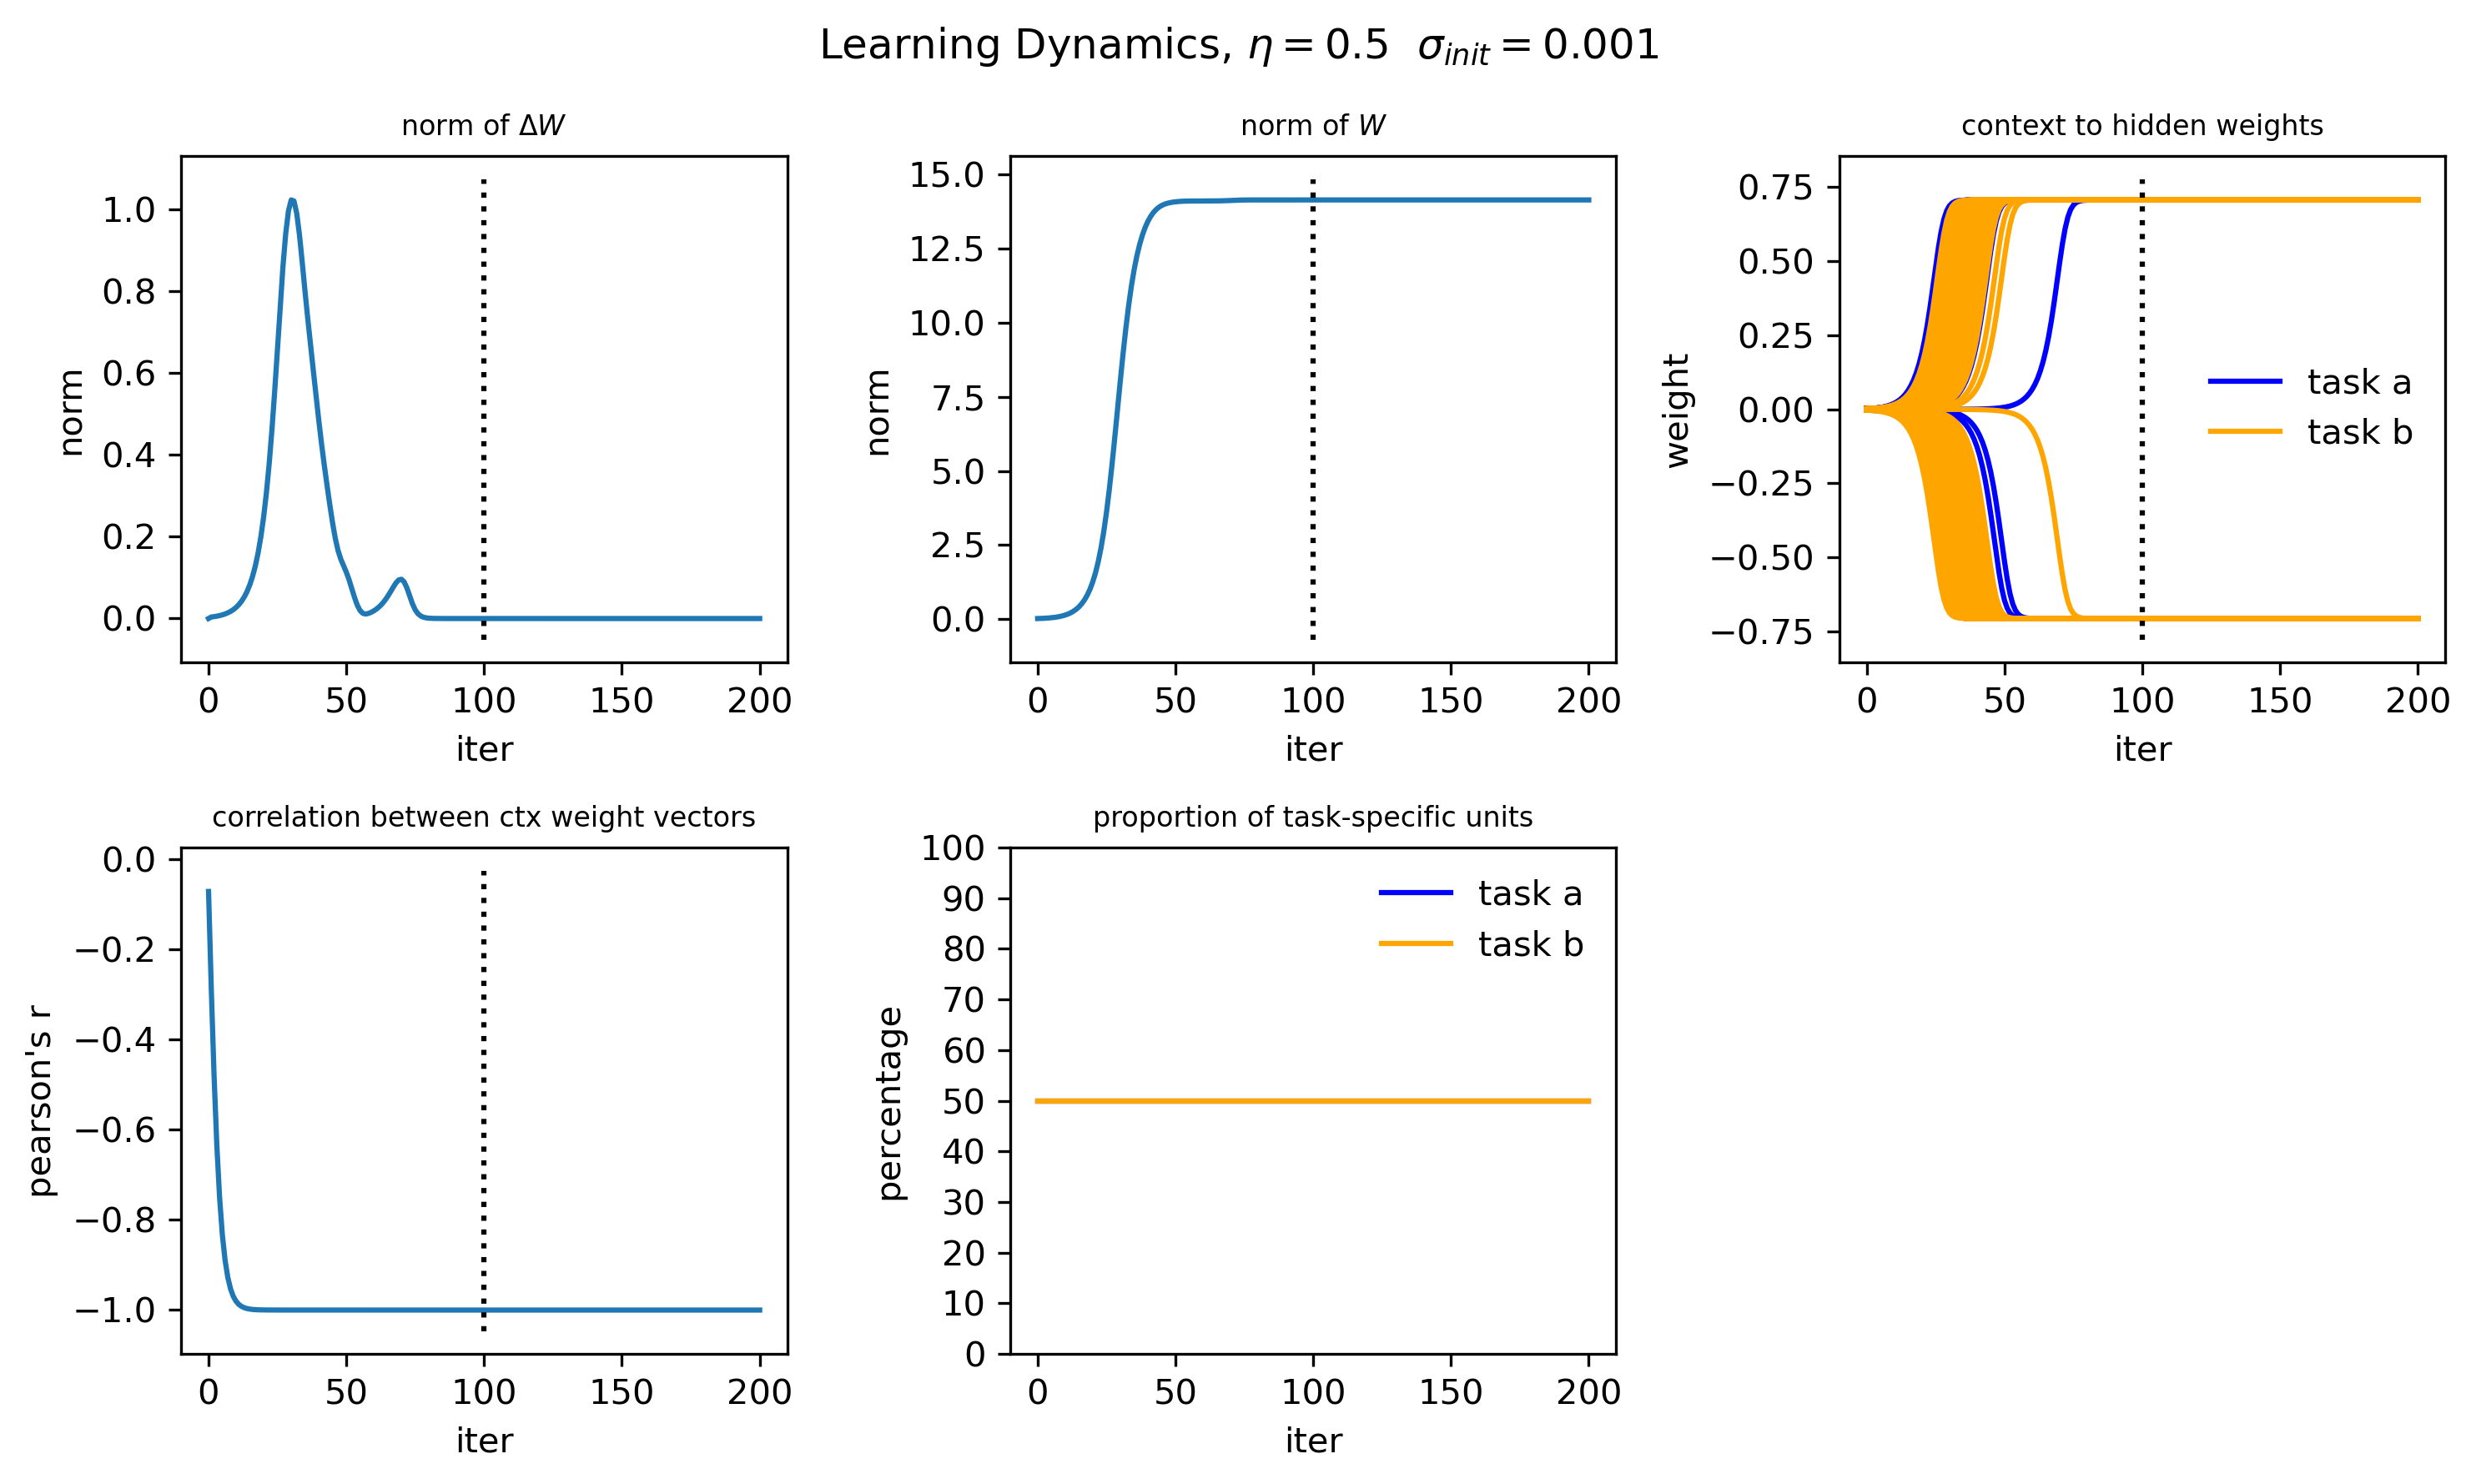

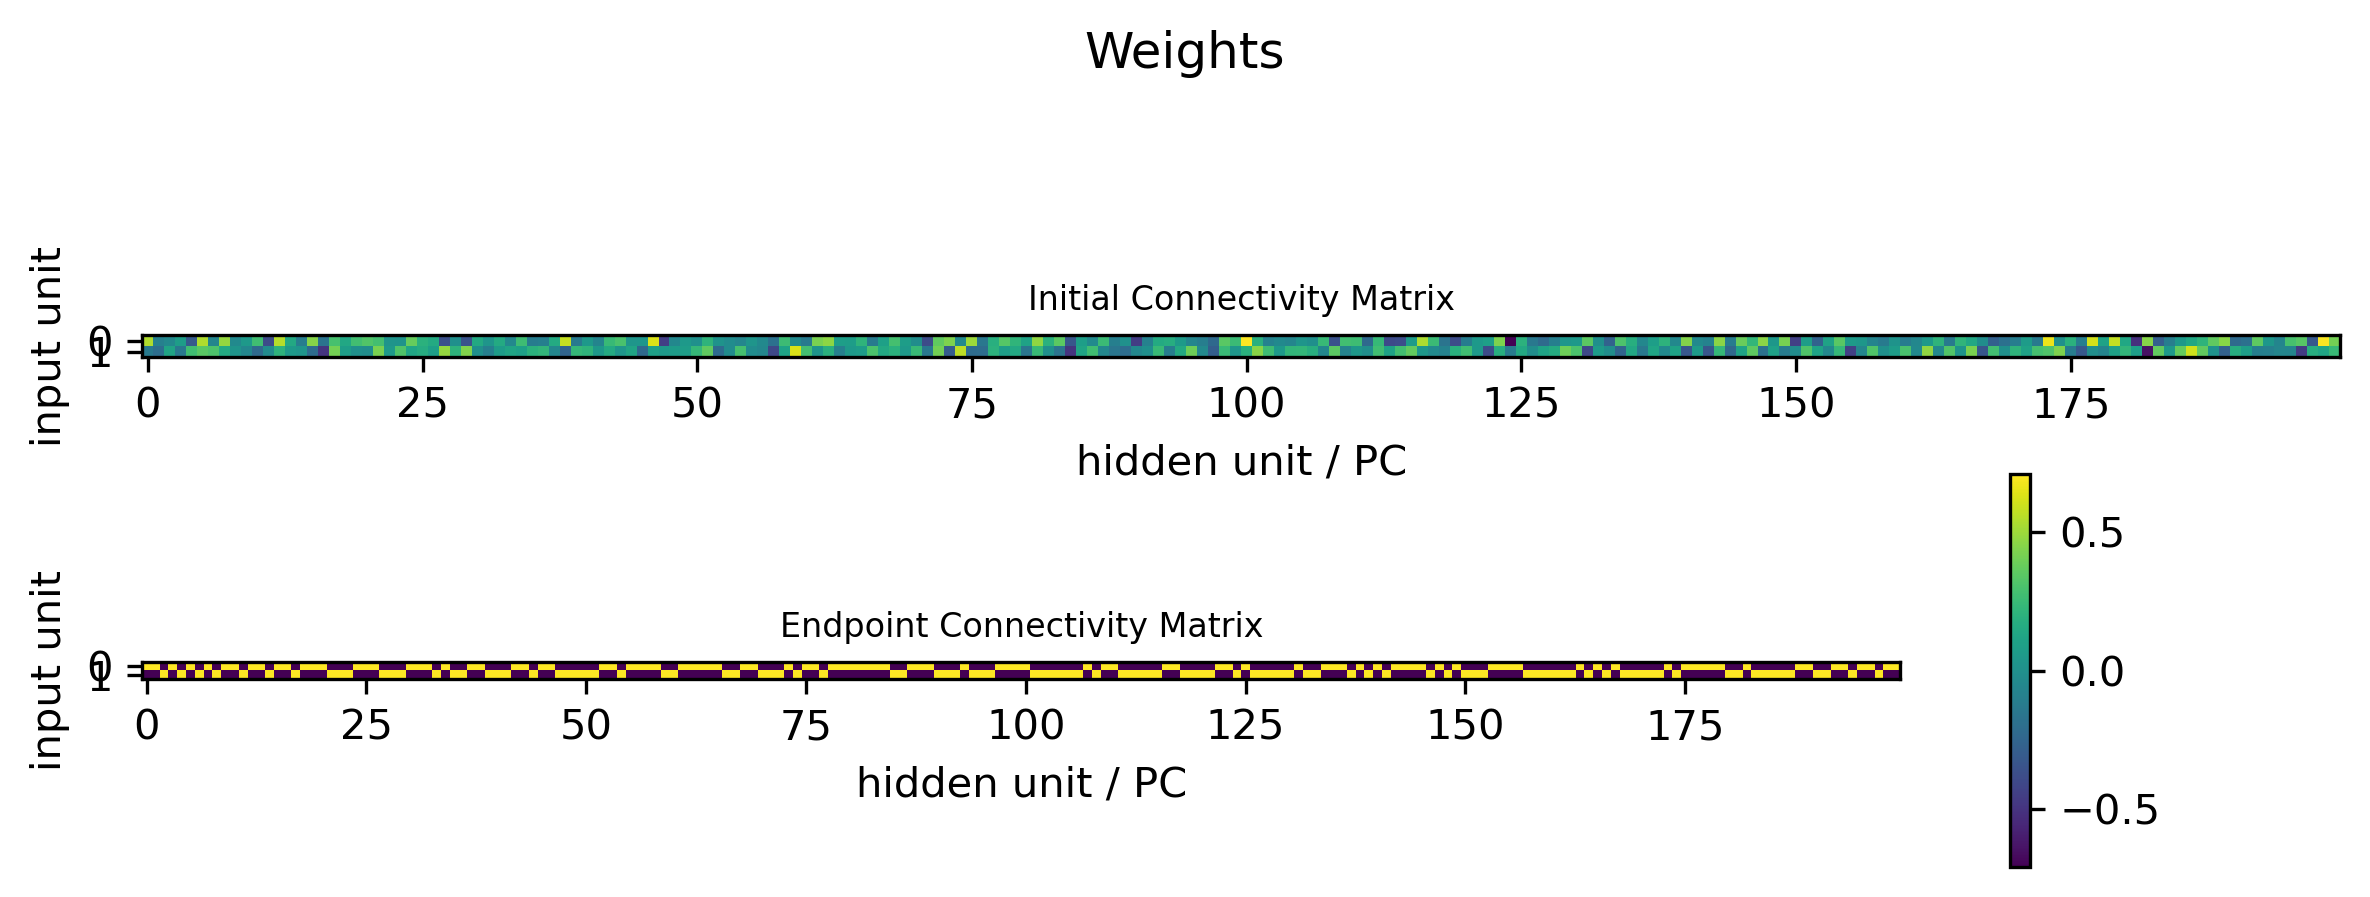

In [27]:
# now Oja only on ctx weights
%matplotlib inline
eta = 5e-1
sigma = 1e-3
n_hidden = 200
n_episodes = 4
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=1,training_schedule='blocked',ctx_avg=False,centering=True)
W = np.random.randn(2,n_hidden)*sigma
delta_ws = []
ws = []
delta_ws.append(0)
ws.append(deepcopy(W))
X = data['x_train'][:,-2:]
for x in X:
    wlist = []
    dwlist = []
    for w in W.T:
        y = w.T@x    
        dw = eta*y*(x-y*w.T)    
        w += dw
        dwlist.append(dw)
        wlist.append(deepcopy(w))
    dwlist = np.array(dwlist)
    
    wlist = np.array(wlist).T
    
     
    
    delta_ws.append(dwlist)
    ws.append(wlist)
plot_ghasla_results()

plt.colorbar()


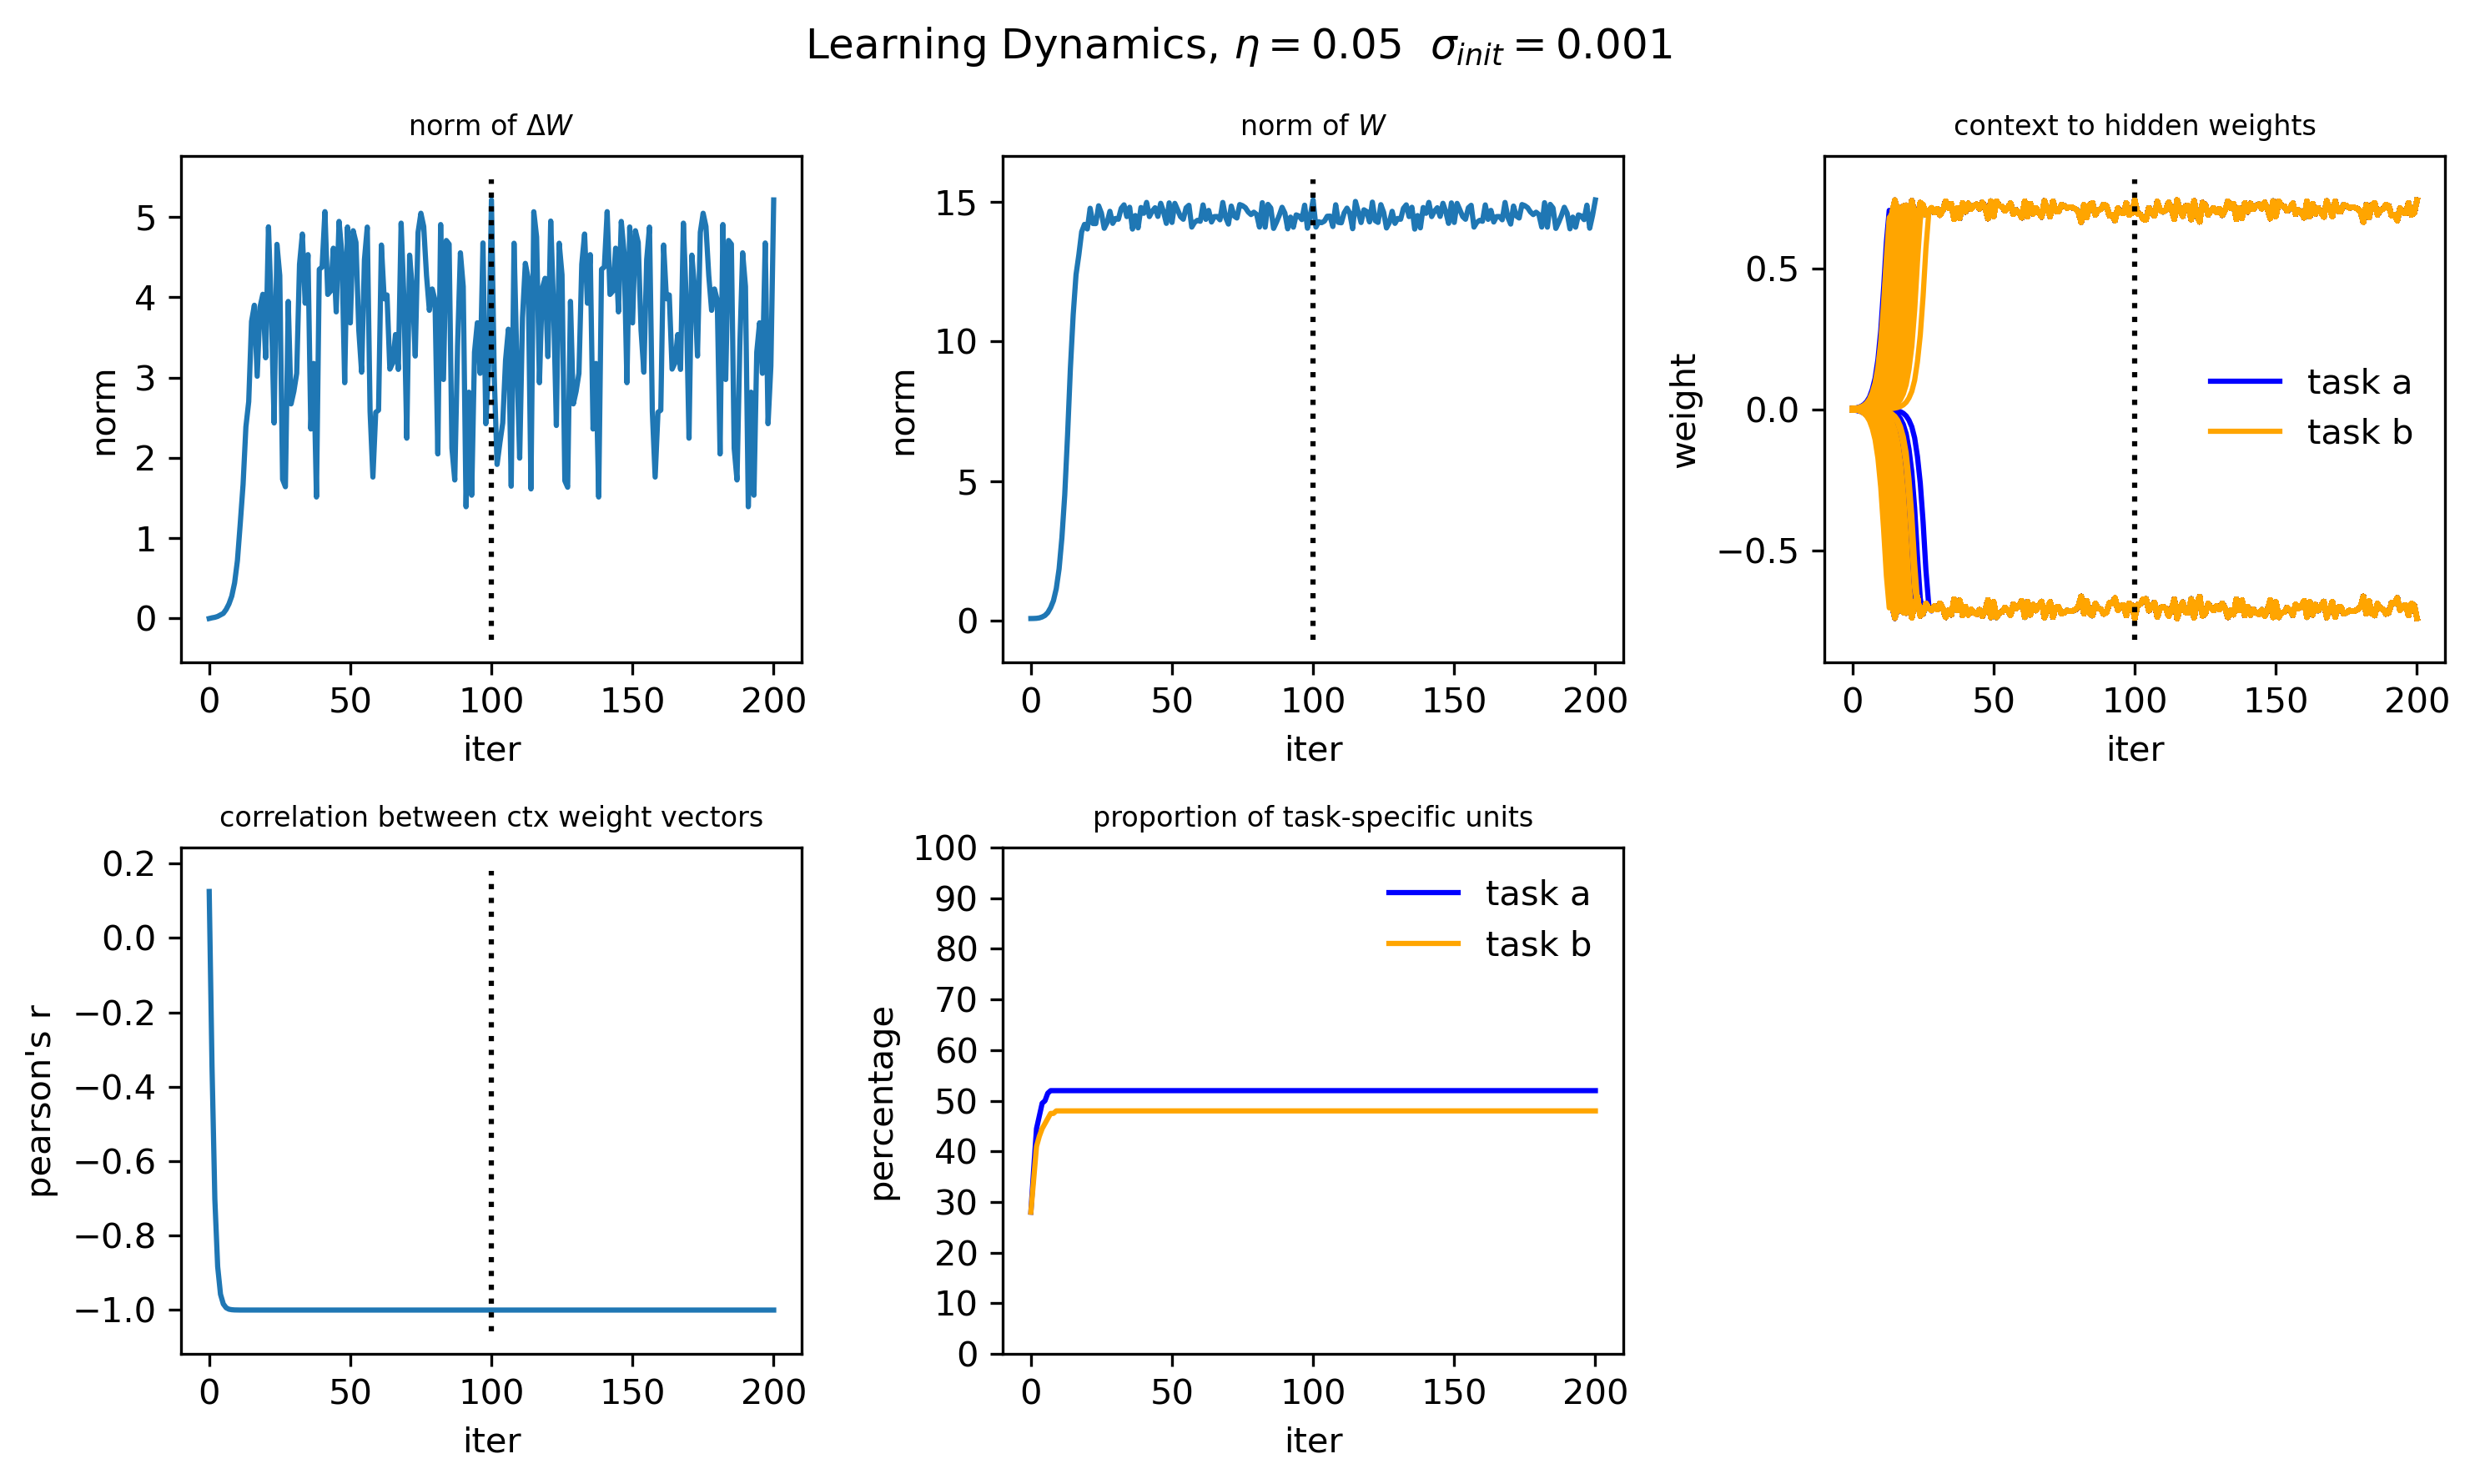

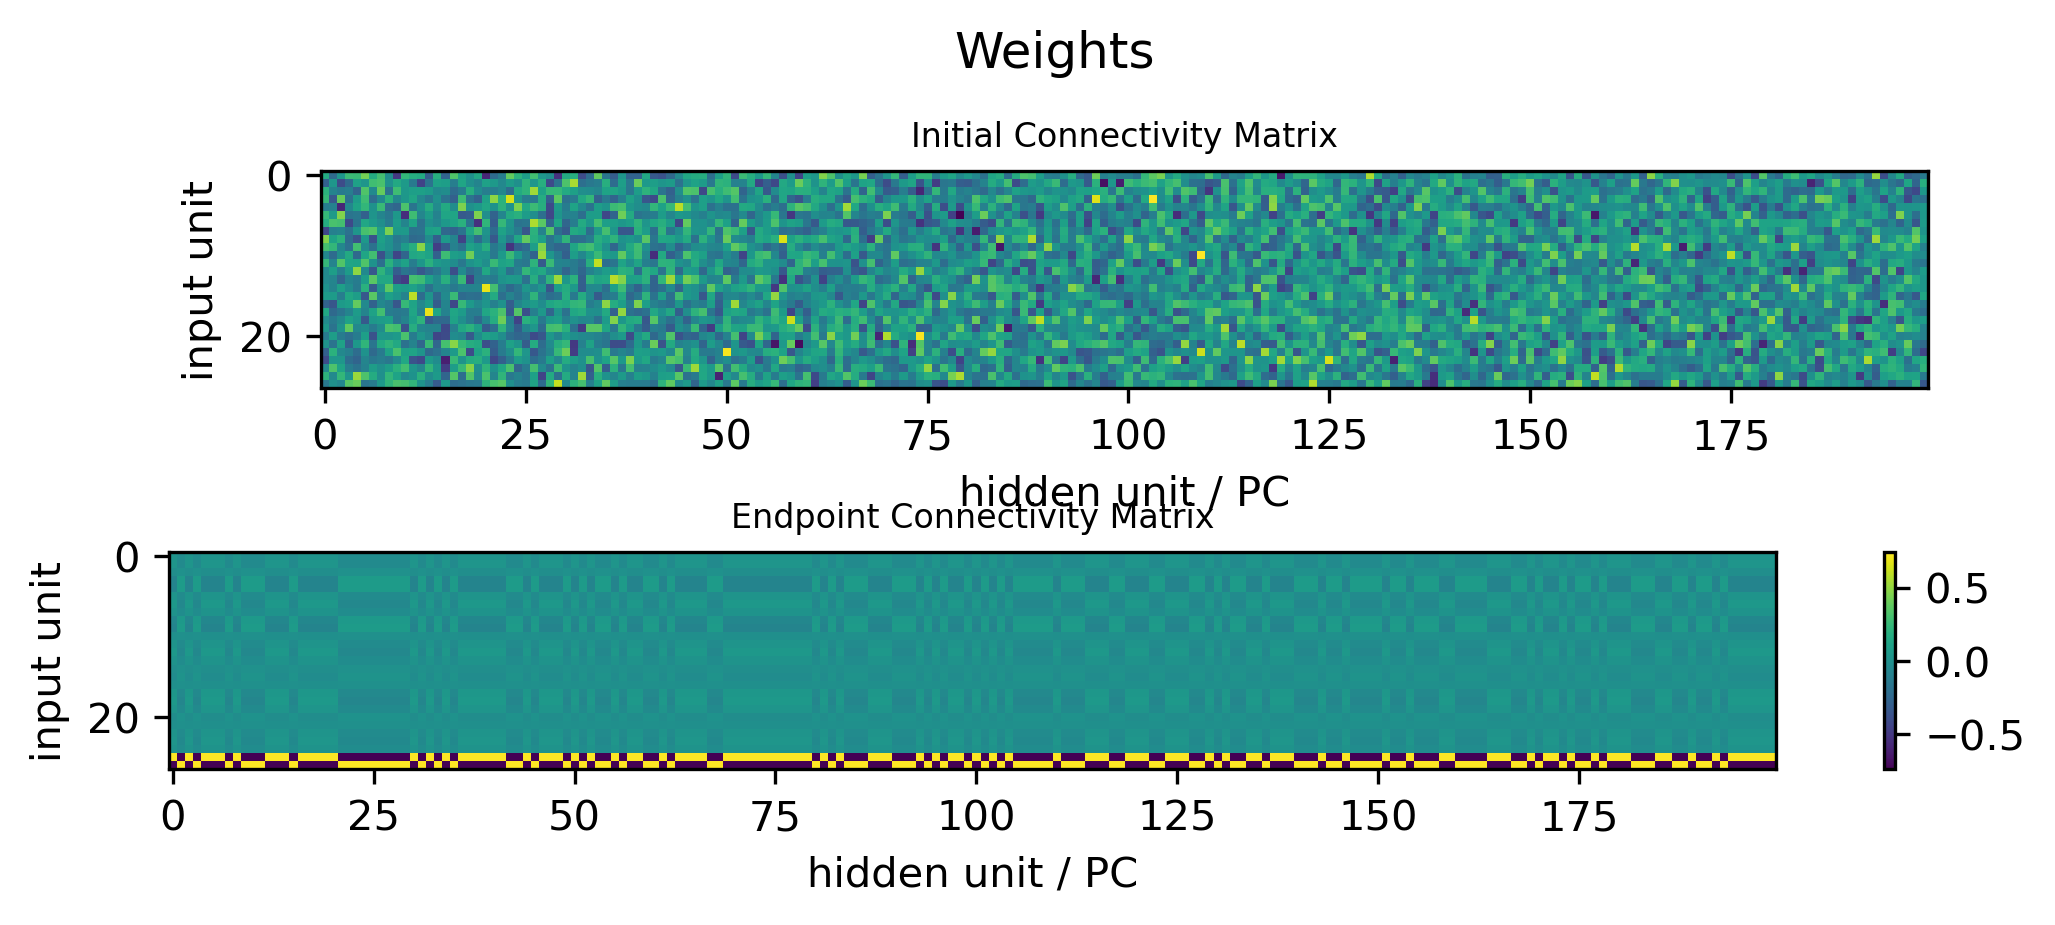

In [28]:
# now Oja on all weights
eta = 5e-2
sigma = 1e-3
n_hidden = 200
n_episodes = 4
n_trials = n_episodes*50
data = make_dataset(n_episodes=n_episodes,ctx_scaling=5,training_schedule='blocked',ctx_avg=False,centering=True)
W = np.random.randn(27,n_hidden)*sigma
delta_ws = []
ws = []
delta_ws.append(0)
ws.append(deepcopy(W))
X = data['x_train'][:,:]
for x in X:
    wlist = []
    dwlist = []
    for w in W.T:
        y = w.T@x    
        dw = eta*y*(x-y*w.T)    
        w += dw
        dwlist.append(dw)
        wlist.append(deepcopy(w))
    dwlist = np.array(dwlist)
    
    wlist = np.array(wlist).T
    
    
    
    delta_ws.append(dwlist)
    ws.append(wlist)
plot_ghasla_results()
plt.colorbar()



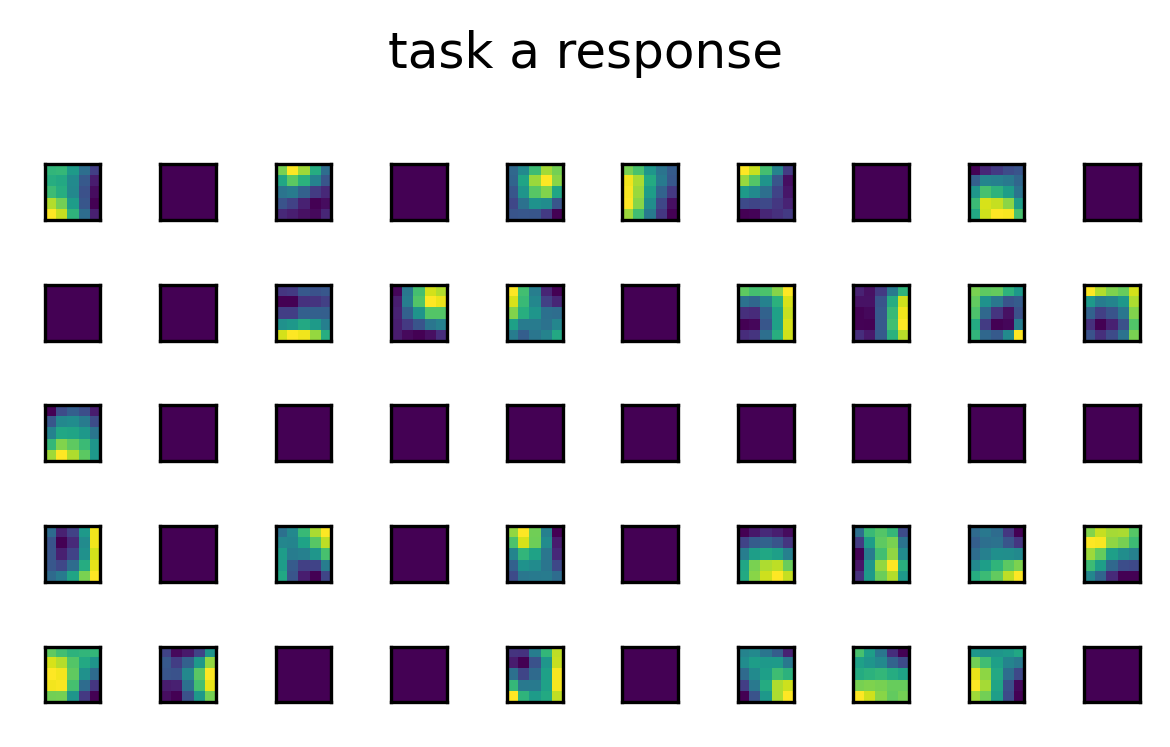

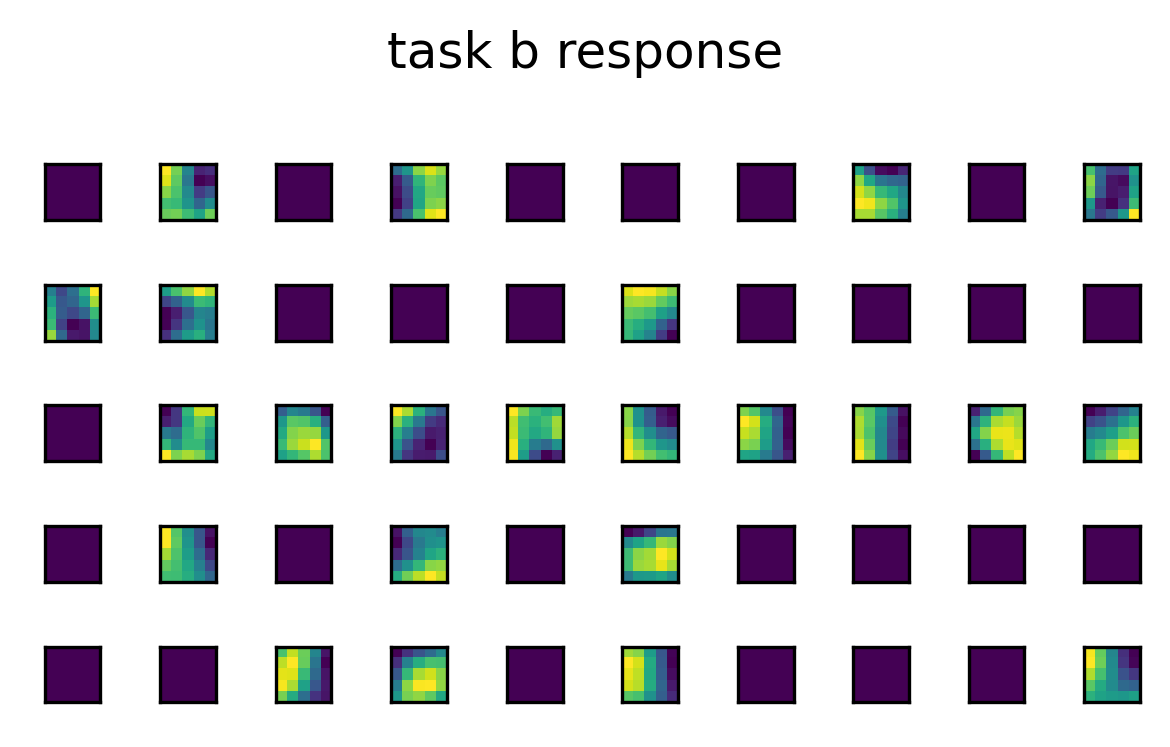

In [35]:
%matplotlib inline
# set stimulus weights to init, to assess whether oja induces any stim selectivity (shouldn't)
ws[-1][:25,:] = ws[0][:25,:]
yh = np.maximum(data['x_all']@ws[-1],0)

f,axs = plt.subplots(5,10,figsize=(4,2.5),dpi=300)
axs = axs.flatten()
for i,ax in enumerate(axs):
    ax.imshow(yh[:25,i].reshape((5,5)))
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle('task a response')
f.set_facecolor('w')
plt.tight_layout()

f,axs = plt.subplots(5,10,figsize=(4,2.5),dpi=300)
axs = axs.flatten()    
for i,ax in enumerate(axs):
    ax.imshow(yh[25:,i].reshape((5,5)))
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle('task b response')
f.set_facecolor('w')
plt.tight_layout()
